In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!/opt/bin/nvidia-smi
!nvcc --version

# ResNet

## Libs setup and imports

In [ ]:
%pip install fastai==2.5.3
%pip install lapixdl==0.7.17
%pip install -U albumentations

In [ ]:
import random
from pathlib import Path

import albumentations as A

import imgaug
import numpy as np
import pandas as pd
from fastai.vision.all import (
    F1Score,
    ImageDataLoaders,
    Normalize,
    PILImage,
    Precision,
    Recall,
    SaveModelCallback,
    ShowGraphCallback,
    Transform,
    accuracy,
    get_image_files,
    get_learner,
    imagenet_stats,
)
from lapixdl.evaluation.evaluate import evaluate_classification
from lapixdl.evaluation.model import Classification

# Fix seed
random.seed(81615)
imgaug.seed(81615)

## Utils

In [ ]:
class AlbumentationsTransform(Transform):
    split_idx = 0

    def __init__(self, aug):
        self.aug = aug

    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))["image"]
        return PILImage.create(aug_img)

# Paths and metadata configuration

Fill the paths accordingly to the structure of the dataset and the output directories.

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

In [ ]:
path_dataset = Path("[dataset root folder]")
path_img = (
    path_dataset / "nuclei_images"
)  # Images root folder. The images must be inside the [train|val|test]/[class] folders.
path_output = Path("[output root folder]")
path_models = path_output / "Models/classification/models_34_v4"

## Train pipeline setup

## Architecture Definition

The complete list of supported models is available at https://github.com/fastai/fastai/tree/2.5.3/fastai/vision/models

In [ ]:
from fastai.vision.models import resnet34

used_model = resnet34

### Pipeline

In [ ]:
# Augmentations setup

augmentations = A.Compose(
    [
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Rotate((-10, 10), p=0.75),
        A.RandomBrightnessContrast(0.1, 0.1, p=0.75),
        A.Affine(p=0.75, shear=0.2),
    ]
)

transforms = [AlbumentationsTransform(augmentations)]

In [ ]:
metrics = [
    accuracy,
    F1Score(average="macro"),
    Precision(average="macro"),
    Recall(average="macro"),
]

In [ ]:
# Organize images as dataframes to better control de dataloader

images_df = pd.DataFrame()
images_df["path"] = get_image_files(path_img)
images_df["is_val"] = images_df["path"].map(lambda e: "/val/" in str(e))
images_df["is_test"] = images_df["path"].map(lambda e: "/test/" in str(e))
images_df["label"] = images_df["path"].map(lambda e: e.parent.stem)

In [ ]:
bs = 256  # Adjust the batch size accordingly to the GPU VRAM capacity

# Creates the dataloader
data = ImageDataLoaders.from_df(
    images_df[~images_df["is_test"]],
    fn_col="path",
    label_col="label",
    valid_col="is_val",
    path="/",
    bs=bs,
    item_tfms=transforms,
    batch_tfms=Normalize.from_stats(*imagenet_stats),
)

In [ ]:
def get_learner(data, load_model=None, unfreeze:bool=False):
  """Creates and setups the learner for each step of the training approach.

  Args:
      data: Dataloader.
      load_model (str): Path to the model to be loaded.
      unfreeze (bool): Indicates if the model should be unfreezed. Defaults to False.
  """
  learn = cnn_learner(data, 
                      used_model, 
                      metrics=metrics, 
                      loss_func=CrossEntropyLossFlat())
                      .to_fp16()
  
  learn.path = path_models
  if(load_model != None):
    learn.load(load_model)
  if(unfreeze):
    learn.unfreeze()
  return learn

# Training

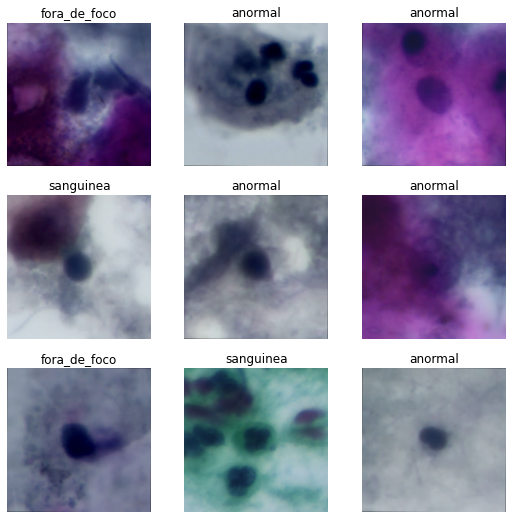

In [ ]:
data.show_batch()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.02290867641568184)

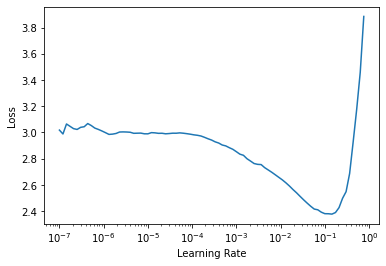

In [ ]:
# Runs the learning rate finder
get_learner(data).lr_find()

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,2.474386,1.744588,0.435616,0.330540,0.338294,0.382289,01:15
1,1.939551,1.328607,0.522023,0.391875,0.393798,0.419766,01:16
2,1.512487,1.162524,0.547102,0.379171,0.400188,0.406273,01:16
3,1.236423,1.042282,0.545627,0.387111,0.426875,0.406076,01:15
4,1.082852,1.016989,0.565016,0.385589,0.383973,0.409967,01:16
5,1.017346,0.975917,0.569441,0.397004,0.476073,0.412609,01:15
6,0.979478,0.968788,0.573656,0.403047,0.518769,0.420999,01:16
7,0.960073,0.943925,0.576396,0.412637,0.492309,0.420384,01:16
8,0.937811,0.941390,0.583351,0.409222,0.460899,0.428149,01:15
9,0.926209,0.924635,0.588830,0.428235,0.502808,0.433062,01:16


Better model found at epoch 0 with f1_score value: 0.3305402774069637.


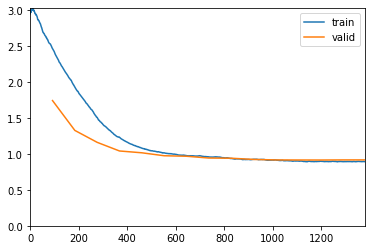

Better model found at epoch 1 with f1_score value: 0.39187494212699825.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Pr

Better model found at epoch 5 with f1_score value: 0.3970043729268677.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 6 with f1_score value: 0.4030465741989606.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 7 with f1_score value: 0.41263749451261983.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 9 with f1_score value: 0.4282349083720349.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 10 with f1_score value: 0.429459646011961.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Pr

In [ ]:
lr = slice(1e-3)  # Choose accordingly to the learning rate finder results
wd = 1e-2  # Weight decay
learn = get_learner(data)
callbacks = [
    SaveModelCallback(
        monitor="f1_score", fname="best_model_stg1", with_opt=True
    ),  # Saves the best model as `fname` in `learn.path` considering the metric defined in `monitor`.
    ShowGraphCallback(),  # Shows the train/validation graph
]

# Train
learn.fit_one_cycle(15, lr_max=lr, wd=wd, cbs=callbacks)

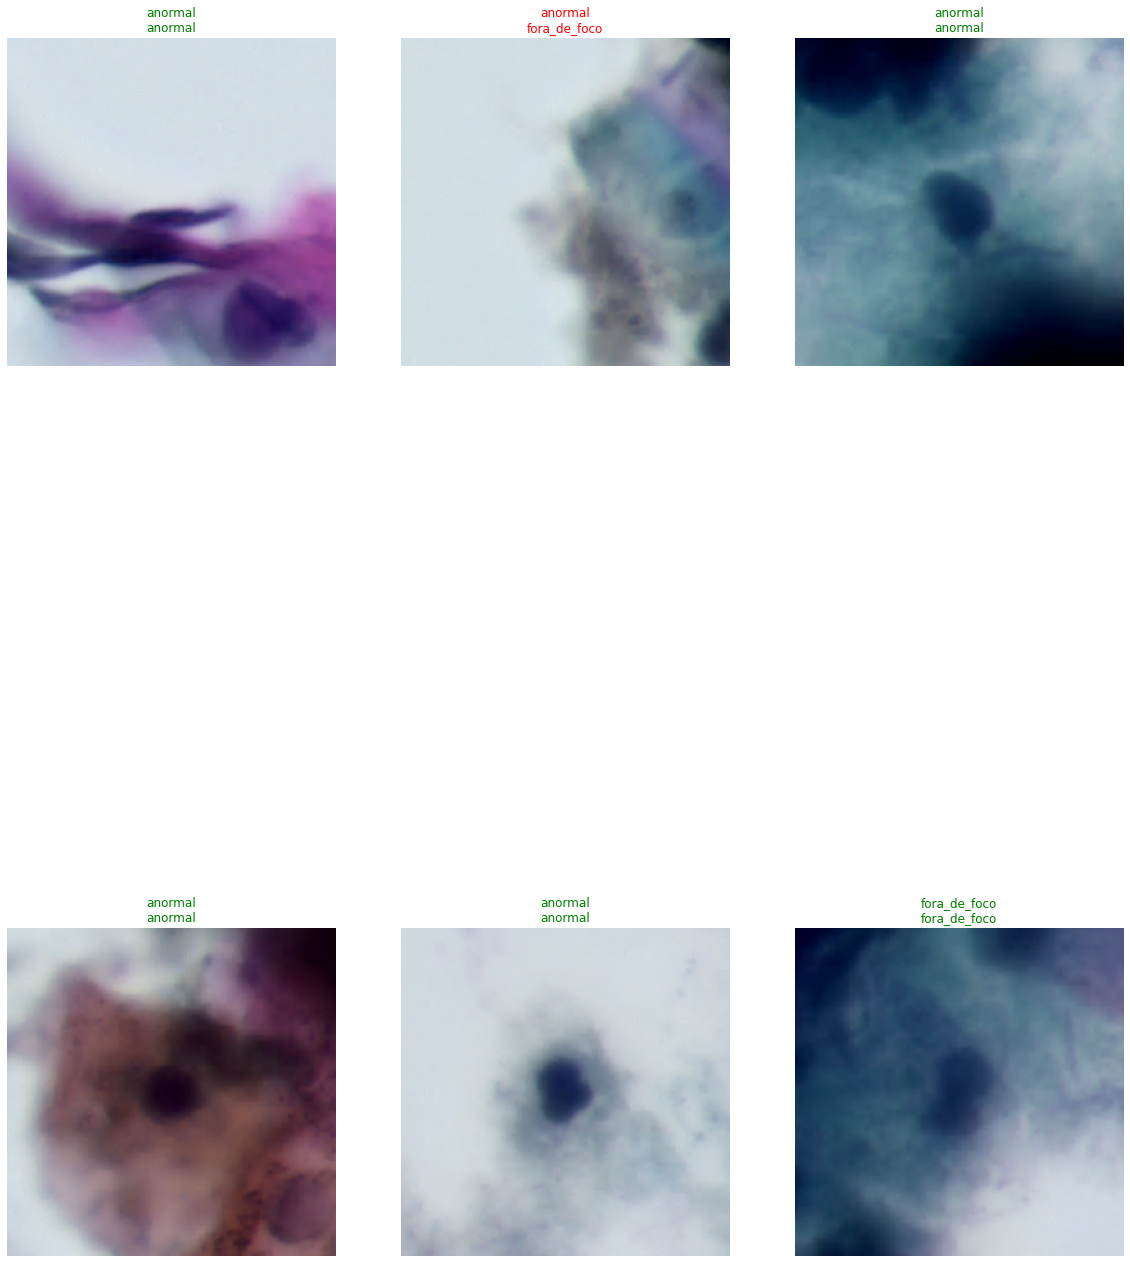

In [ ]:
get_learner(data, "best_model_stg1").show_results(
    max_n=6, figsize=(20, 30)
)  # Shows example results of the trained model

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.0691830962896347)

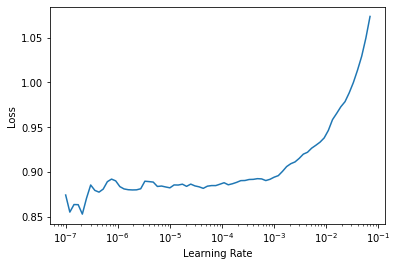

In [ ]:
# Load, unfreeze and lr finder for finetunning
get_learner(data, "best_model_stg1", True).lr_find()

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,0.891220,0.928622,0.590516,0.416079,0.496447,0.430724,01:25
1,0.879627,0.893358,0.606112,0.446536,0.532237,0.452765,01:23
2,0.869689,0.883405,0.609062,0.443328,0.517824,0.453327,01:23
3,0.847449,0.862027,0.627397,0.457980,0.518314,0.467735,01:22
4,0.826111,0.843040,0.628873,0.472242,0.525411,0.470772,01:23
5,0.816850,0.831325,0.634984,0.481027,0.524491,0.478903,01:23
6,0.788784,0.826324,0.649737,0.480913,0.539220,0.479585,01:23
7,0.763790,0.816625,0.645943,0.499776,0.522893,0.499219,01:23
8,0.751624,0.811684,0.648894,0.503248,0.548577,0.494386,01:23
9,0.728228,0.815923,0.647418,0.509602,0.533249,0.509280,01:23


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with f1_score value: 0.4160788976810143.


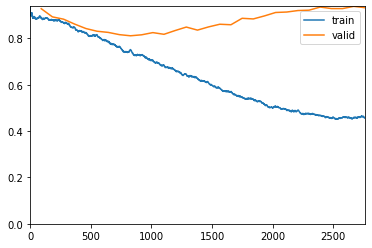

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with f1_score value: 0.44653574538288704.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 3 with f1_score value: 0.4579797357026596.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 4 with f1_score value: 0.4722418212180717.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 5 with f1_score value: 0.4810266072969061.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 7 with f1_score value: 0.4997764509715627.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 8 with f1_score value: 0.5032483603559176.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 9 with f1_score value: 0.50960233247939.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Pr

Better model found at epoch 15 with f1_score value: 0.520209208295054.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Pr

In [ ]:
lr = slice(1e-5, 1e-4)
wd = 1e-2
learn = get_learner(data, "best_model_stg1", True)
callbacks = [
    SaveModelCallback(monitor="f1_score", fname="best_model_stg2", with_opt=True),
    ShowGraphCallback(),
]

learn.fit_one_cycle(30, lr_max=lr, wd=wd, cbs=callbacks)

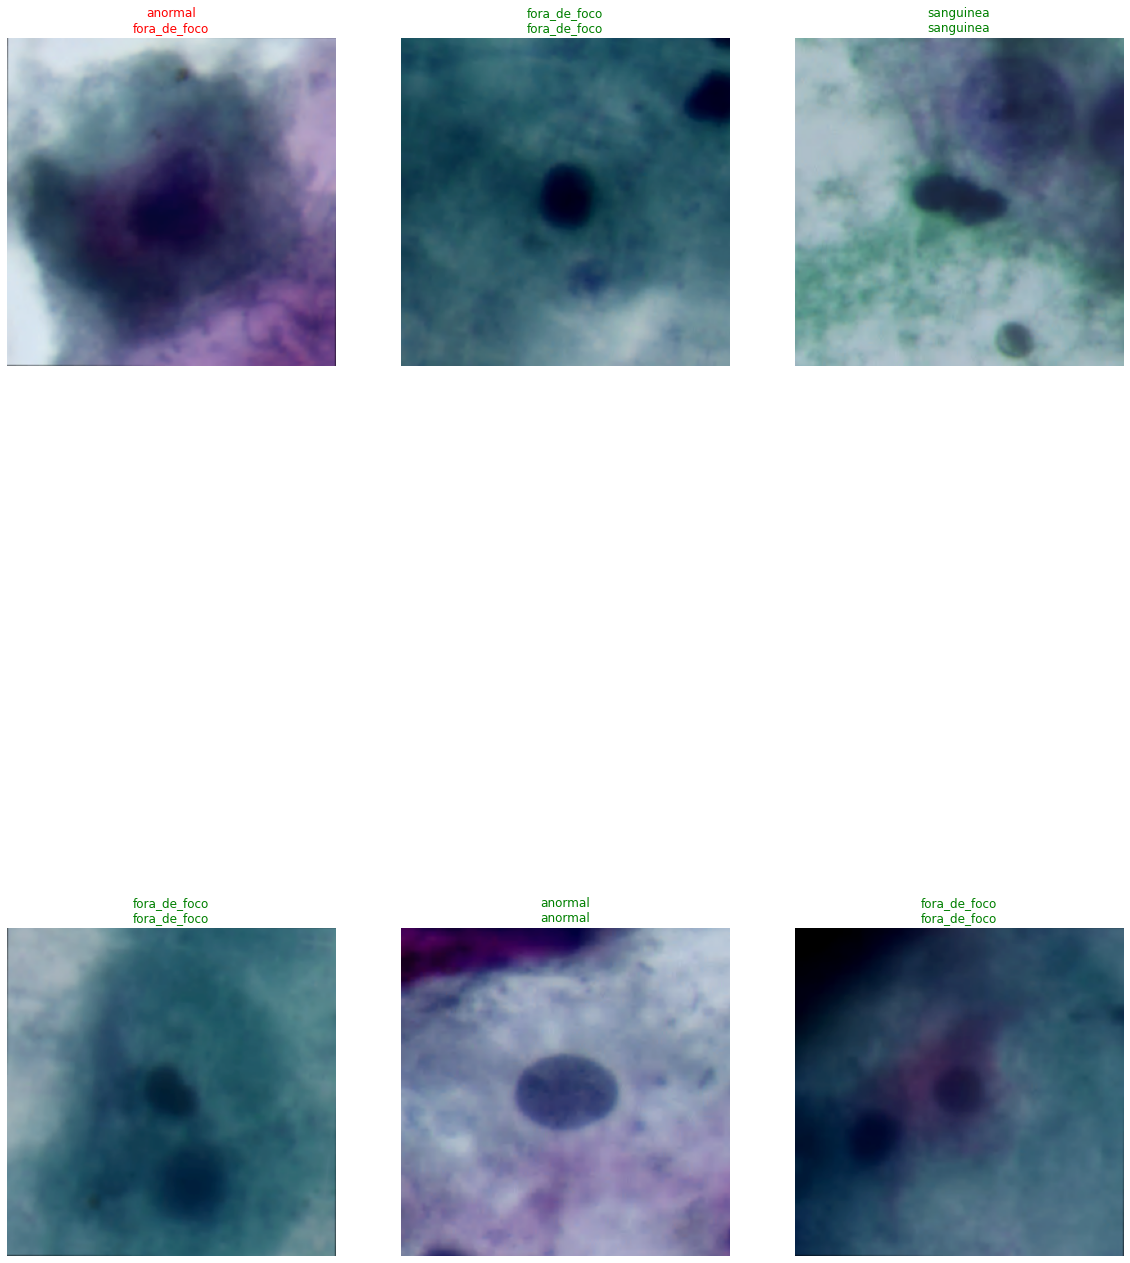

In [ ]:
get_learner(data, "best_model_stg2").show_results(max_n=6, figsize=(20, 30))

## Test

Run the metrics evaluations on the test set

In [ ]:
bs = 1
data_test = ImageDataLoaders.from_df(
    images_df[~images_df["is_bbox_only"]],
    fn_col="path",
    label_col="label",
    valid_col="is_test",
    path="/",
    bs=bs,
    batch_tfms=Normalize.from_stats(*imagenet_stats),
)

In [ ]:
learn = get_learner(data_test, "best_model_stg2")
ds_test = data_test.valid_ds

In [ ]:
# Iterators to convert to the LapixDL input format


def gt_classifications(ds):
    for (img, cls) in ds:
        yield Classification(int(cls))


def pred_classifications(ds):
    for (img, cls) in ds:
        (cls_name, pred_cls, scores) = learn.predict(img)
        yield Classification(int(pred_cls), scores[int(pred_cls)])

In [ ]:
evaluation_test = evaluate_classification(
    gt_classifications(ds_test), pred_classifications(ds_test), ds_test.vocab
)

0 samples [00:00, ? samples/s]

1 samples [00:00,  5.55 samples/s]

4 samples [00:00, 13.57 samples/s]

7 samples [00:00, 16.68 samples/s]

10 samples [00:00, 19.01 samples/s]

13 samples [00:00, 20.36 samples/s]

16 samples [00:00, 21.03 samples/s]

19 samples [00:00, 21.74 samples/s]

22 samples [00:01, 22.27 samples/s]

25 samples [00:01, 22.42 samples/s]

28 samples [00:01, 22.86 samples/s]

31 samples [00:01, 23.10 samples/s]

34 samples [00:01, 23.35 samples/s]

37 samples [00:01, 23.58 samples/s]

40 samples [00:01, 23.42 samples/s]

43 samples [00:02, 23.19 samples/s]

46 samples [00:02, 22.90 samples/s]

49 samples [00:02, 22.40 samples/s]

52 samples [00:02, 22.19 samples/s]

55 samples [00:02, 21.93 samples/s]

58 samples [00:02, 21.51 samples/s]

61 samples [00:02, 21.47 samples/s]

64 samples [00:02, 21.58 samples/s]

67 samples [00:03, 21.57 samples/s]

70 samples [00:03, 21.47 samples/s]

73 samples [00:03, 21.13 samples/s]

76 samples [00:03, 21.14 samples/s]

79 samples [00:03, 21.43 samples/s]

82 samples [00:03, 20.73 samples/s]

85 samples [00:03, 20.88 samples/s]

88 samples [00:04, 20.91 samples/s]

91 samples [00:04, 20.82 samples/s]

94 samples [00:04, 20.73 samples/s]

97 samples [00:04, 20.76 samples/s]

100 samples [00:04, 21.09 samples/s]

103 samples [00:04, 20.89 samples/s]

106 samples [00:05, 20.91 samples/s]

109 samples [00:05, 20.83 samples/s]

112 samples [00:05, 20.85 samples/s]

115 samples [00:05, 20.55 samples/s]

118 samples [00:05, 20.47 samples/s]

121 samples [00:05, 20.59 samples/s]

124 samples [00:05, 20.86 samples/s]

127 samples [00:06, 20.63 samples/s]

130 samples [00:06, 20.95 samples/s]

133 samples [00:06, 21.12 samples/s]

136 samples [00:06, 21.11 samples/s]

139 samples [00:06, 20.87 samples/s]

142 samples [00:06, 20.80 samples/s]

145 samples [00:06, 20.88 samples/s]

148 samples [00:07, 20.73 samples/s]

151 samples [00:07, 20.82 samples/s]

154 samples [00:07, 21.24 samples/s]

157 samples [00:07, 21.22 samples/s]

160 samples [00:07, 21.04 samples/s]

163 samples [00:07, 21.24 samples/s]

166 samples [00:07, 21.62 samples/s]

169 samples [00:08, 21.50 samples/s]

172 samples [00:08, 21.32 samples/s]

175 samples [00:08, 21.15 samples/s]

178 samples [00:08, 20.92 samples/s]

181 samples [00:08, 20.65 samples/s]

184 samples [00:08, 20.68 samples/s]

187 samples [00:08, 20.68 samples/s]

190 samples [00:09, 20.43 samples/s]

193 samples [00:09, 20.52 samples/s]

196 samples [00:09, 20.81 samples/s]

199 samples [00:09, 20.83 samples/s]

202 samples [00:09, 20.44 samples/s]

205 samples [00:09, 20.35 samples/s]

208 samples [00:09, 20.33 samples/s]

211 samples [00:10, 20.18 samples/s]

214 samples [00:10, 20.34 samples/s]

217 samples [00:10, 20.49 samples/s]

220 samples [00:10, 20.59 samples/s]

223 samples [00:10, 20.87 samples/s]

226 samples [00:10, 20.86 samples/s]

229 samples [00:10, 20.47 samples/s]

232 samples [00:11, 20.75 samples/s]

235 samples [00:11, 20.88 samples/s]

238 samples [00:11, 20.89 samples/s]

241 samples [00:11, 20.87 samples/s]

244 samples [00:11, 20.83 samples/s]

247 samples [00:11, 20.70 samples/s]

250 samples [00:11, 20.52 samples/s]

253 samples [00:12, 20.18 samples/s]

256 samples [00:12, 20.42 samples/s]

259 samples [00:12, 20.48 samples/s]

262 samples [00:12, 20.00 samples/s]

265 samples [00:12, 19.82 samples/s]

268 samples [00:12, 20.13 samples/s]

271 samples [00:12, 20.41 samples/s]

274 samples [00:13, 20.32 samples/s]

277 samples [00:13, 20.12 samples/s]

280 samples [00:13, 19.96 samples/s]

283 samples [00:13, 20.25 samples/s]

286 samples [00:13, 20.42 samples/s]

289 samples [00:13, 20.56 samples/s]

292 samples [00:14, 20.60 samples/s]

295 samples [00:14, 20.15 samples/s]

298 samples [00:14, 19.75 samples/s]

300 samples [00:14, 19.52 samples/s]

303 samples [00:14, 19.59 samples/s]

305 samples [00:14, 19.50 samples/s]

308 samples [00:14, 19.72 samples/s]

310 samples [00:14, 19.71 samples/s]

312 samples [00:15, 19.56 samples/s]

315 samples [00:15, 20.02 samples/s]

318 samples [00:15, 20.26 samples/s]

321 samples [00:15, 19.92 samples/s]

323 samples [00:15, 19.63 samples/s]

325 samples [00:15, 19.71 samples/s]

327 samples [00:15, 19.77 samples/s]

330 samples [00:15, 19.76 samples/s]

332 samples [00:16, 19.79 samples/s]

334 samples [00:16, 19.22 samples/s]

336 samples [00:16, 18.96 samples/s]

339 samples [00:16, 19.60 samples/s]

341 samples [00:16, 19.56 samples/s]

344 samples [00:16, 19.87 samples/s]

346 samples [00:16, 19.65 samples/s]

348 samples [00:16, 19.44 samples/s]

351 samples [00:17, 19.92 samples/s]

353 samples [00:17, 19.43 samples/s]

355 samples [00:17, 19.53 samples/s]

357 samples [00:17, 19.48 samples/s]

360 samples [00:17, 20.07 samples/s]

362 samples [00:17, 19.89 samples/s]

365 samples [00:17, 20.66 samples/s]

368 samples [00:17, 20.62 samples/s]

371 samples [00:18, 20.60 samples/s]

374 samples [00:18, 20.51 samples/s]

377 samples [00:18, 20.60 samples/s]

380 samples [00:18, 20.59 samples/s]

383 samples [00:18, 19.89 samples/s]

385 samples [00:18, 19.72 samples/s]

388 samples [00:18, 19.88 samples/s]

390 samples [00:18, 19.59 samples/s]

393 samples [00:19, 19.75 samples/s]

395 samples [00:19, 19.69 samples/s]

397 samples [00:19, 19.71 samples/s]

399 samples [00:19, 19.63 samples/s]

401 samples [00:19, 19.31 samples/s]

403 samples [00:19, 19.12 samples/s]

405 samples [00:19, 19.20 samples/s]

407 samples [00:19, 19.32 samples/s]

409 samples [00:19, 19.27 samples/s]

411 samples [00:20, 19.25 samples/s]

414 samples [00:20, 19.39 samples/s]

416 samples [00:20, 19.25 samples/s]

418 samples [00:20, 19.42 samples/s]

420 samples [00:20, 19.57 samples/s]

422 samples [00:20, 19.15 samples/s]

424 samples [00:20, 19.32 samples/s]

426 samples [00:20, 19.19 samples/s]

429 samples [00:20, 19.70 samples/s]

431 samples [00:21, 19.11 samples/s]

434 samples [00:21, 19.27 samples/s]

436 samples [00:21, 19.19 samples/s]

439 samples [00:21, 19.47 samples/s]

441 samples [00:21, 18.90 samples/s]

443 samples [00:21, 18.56 samples/s]

446 samples [00:21, 19.14 samples/s]

448 samples [00:21, 18.90 samples/s]

450 samples [00:22, 19.06 samples/s]

452 samples [00:22, 19.09 samples/s]

455 samples [00:22, 19.29 samples/s]

457 samples [00:22, 19.30 samples/s]

459 samples [00:22, 19.22 samples/s]

461 samples [00:22, 18.99 samples/s]

463 samples [00:22, 19.24 samples/s]

465 samples [00:22, 19.03 samples/s]

467 samples [00:22, 19.01 samples/s]

469 samples [00:23, 19.07 samples/s]

472 samples [00:23, 19.28 samples/s]

474 samples [00:23, 19.46 samples/s]

476 samples [00:23, 19.59 samples/s]

478 samples [00:23, 18.83 samples/s]

480 samples [00:23, 19.02 samples/s]

482 samples [00:23, 18.72 samples/s]

484 samples [00:23, 18.29 samples/s]

486 samples [00:23, 18.71 samples/s]

488 samples [00:24, 18.88 samples/s]

490 samples [00:24, 19.15 samples/s]

492 samples [00:24, 18.40 samples/s]

494 samples [00:24, 18.19 samples/s]

496 samples [00:24, 18.38 samples/s]

498 samples [00:24, 18.33 samples/s]

501 samples [00:24, 19.22 samples/s]

504 samples [00:24, 19.67 samples/s]

506 samples [00:25, 19.25 samples/s]

508 samples [00:25, 18.89 samples/s]

510 samples [00:25, 18.92 samples/s]

512 samples [00:25, 18.99 samples/s]

514 samples [00:25, 19.08 samples/s]

516 samples [00:25, 18.82 samples/s]

518 samples [00:25, 18.86 samples/s]

520 samples [00:25, 19.12 samples/s]

522 samples [00:25, 19.16 samples/s]

524 samples [00:25, 18.91 samples/s]

526 samples [00:26, 18.75 samples/s]

528 samples [00:26, 19.03 samples/s]

530 samples [00:26, 19.18 samples/s]

532 samples [00:26, 18.98 samples/s]

534 samples [00:26, 19.22 samples/s]

536 samples [00:26, 19.12 samples/s]

538 samples [00:26, 19.13 samples/s]

540 samples [00:26, 19.00 samples/s]

543 samples [00:26, 18.99 samples/s]

545 samples [00:27, 19.10 samples/s]

547 samples [00:27, 19.11 samples/s]

549 samples [00:27, 19.03 samples/s]

551 samples [00:27, 19.04 samples/s]

553 samples [00:27, 18.95 samples/s]

555 samples [00:27, 19.06 samples/s]

557 samples [00:27, 18.77 samples/s]

559 samples [00:27, 18.63 samples/s]

561 samples [00:27, 18.43 samples/s]

563 samples [00:28, 18.37 samples/s]

565 samples [00:28, 18.61 samples/s]

567 samples [00:28, 18.96 samples/s]

569 samples [00:28, 18.78 samples/s]

572 samples [00:28, 19.37 samples/s]

574 samples [00:28, 18.99 samples/s]

576 samples [00:28, 18.66 samples/s]

578 samples [00:28, 18.67 samples/s]

580 samples [00:28, 18.54 samples/s]

582 samples [00:29, 18.70 samples/s]

584 samples [00:29, 18.02 samples/s]

586 samples [00:29, 18.21 samples/s]

588 samples [00:29, 18.13 samples/s]

590 samples [00:29, 18.63 samples/s]

592 samples [00:29, 18.62 samples/s]

595 samples [00:29, 19.26 samples/s]

597 samples [00:29, 19.36 samples/s]

600 samples [00:29, 20.03 samples/s]

602 samples [00:30, 19.55 samples/s]

605 samples [00:30, 20.25 samples/s]

608 samples [00:30, 20.04 samples/s]

611 samples [00:30, 20.23 samples/s]

614 samples [00:30, 20.15 samples/s]

617 samples [00:30, 19.99 samples/s]

619 samples [00:30, 19.57 samples/s]

621 samples [00:31, 19.29 samples/s]

624 samples [00:31, 19.81 samples/s]

627 samples [00:31, 20.42 samples/s]

630 samples [00:31, 20.27 samples/s]

633 samples [00:31, 20.54 samples/s]

636 samples [00:31, 20.21 samples/s]

639 samples [00:31, 19.50 samples/s]

641 samples [00:32, 19.52 samples/s]

643 samples [00:32, 19.30 samples/s]

646 samples [00:32, 19.89 samples/s]

649 samples [00:32, 20.26 samples/s]

652 samples [00:32, 20.24 samples/s]

655 samples [00:32, 20.30 samples/s]

658 samples [00:32, 19.69 samples/s]

660 samples [00:33, 19.42 samples/s]

663 samples [00:33, 19.74 samples/s]

666 samples [00:33, 19.87 samples/s]

668 samples [00:33, 19.38 samples/s]

670 samples [00:33, 19.40 samples/s]

672 samples [00:33, 19.39 samples/s]

675 samples [00:33, 19.57 samples/s]

678 samples [00:33, 19.83 samples/s]

680 samples [00:34, 19.77 samples/s]

683 samples [00:34, 20.30 samples/s]

686 samples [00:34, 20.28 samples/s]

689 samples [00:34, 19.98 samples/s]

691 samples [00:34, 19.44 samples/s]

693 samples [00:34, 19.31 samples/s]

695 samples [00:34, 19.37 samples/s]

698 samples [00:34, 20.01 samples/s]

700 samples [00:35, 19.52 samples/s]

702 samples [00:35, 19.56 samples/s]

705 samples [00:35, 20.14 samples/s]

708 samples [00:35, 20.06 samples/s]

710 samples [00:35, 19.92 samples/s]

712 samples [00:35, 19.83 samples/s]

714 samples [00:35, 19.55 samples/s]

716 samples [00:35, 19.30 samples/s]

718 samples [00:35, 19.13 samples/s]

721 samples [00:36, 20.10 samples/s]

723 samples [00:36, 19.70 samples/s]

726 samples [00:36, 20.26 samples/s]

729 samples [00:36, 20.12 samples/s]

732 samples [00:36, 20.13 samples/s]

735 samples [00:36, 19.80 samples/s]

737 samples [00:36, 19.46 samples/s]

739 samples [00:37, 19.11 samples/s]

741 samples [00:37, 19.22 samples/s]

743 samples [00:37, 19.19 samples/s]

746 samples [00:37, 19.58 samples/s]

748 samples [00:37, 19.13 samples/s]

750 samples [00:37, 18.93 samples/s]

753 samples [00:37, 19.75 samples/s]

755 samples [00:37, 19.58 samples/s]

757 samples [00:37, 19.67 samples/s]

759 samples [00:38, 19.02 samples/s]

762 samples [00:38, 19.87 samples/s]

764 samples [00:38, 19.64 samples/s]

766 samples [00:38, 19.33 samples/s]

768 samples [00:38, 19.41 samples/s]

770 samples [00:38, 19.27 samples/s]

773 samples [00:38, 19.80 samples/s]

775 samples [00:38, 19.77 samples/s]

777 samples [00:38, 19.15 samples/s]

780 samples [00:39, 20.09 samples/s]

782 samples [00:39, 19.72 samples/s]

785 samples [00:39, 19.85 samples/s]

787 samples [00:39, 19.44 samples/s]

789 samples [00:39, 19.33 samples/s]

791 samples [00:39, 19.36 samples/s]

793 samples [00:39, 19.44 samples/s]

796 samples [00:39, 19.81 samples/s]

798 samples [00:40, 19.48 samples/s]

800 samples [00:40, 19.27 samples/s]

802 samples [00:40, 19.39 samples/s]

805 samples [00:40, 19.84 samples/s]

807 samples [00:40, 19.64 samples/s]

810 samples [00:40, 20.02 samples/s]

812 samples [00:40, 19.74 samples/s]

814 samples [00:40, 19.54 samples/s]

817 samples [00:40, 19.92 samples/s]

820 samples [00:41, 20.19 samples/s]

823 samples [00:41, 19.99 samples/s]

826 samples [00:41, 20.39 samples/s]

829 samples [00:41, 20.20 samples/s]

832 samples [00:41, 20.20 samples/s]

835 samples [00:41, 19.47 samples/s]

837 samples [00:42, 18.86 samples/s]

839 samples [00:42, 19.07 samples/s]

841 samples [00:42, 18.86 samples/s]

843 samples [00:42, 18.63 samples/s]

845 samples [00:42, 18.82 samples/s]

847 samples [00:42, 18.96 samples/s]

850 samples [00:42, 19.04 samples/s]

852 samples [00:42, 18.86 samples/s]

854 samples [00:42, 18.61 samples/s]

857 samples [00:43, 19.61 samples/s]

859 samples [00:43, 19.45 samples/s]

861 samples [00:43, 19.60 samples/s]

864 samples [00:43, 19.89 samples/s]

866 samples [00:43, 19.55 samples/s]

868 samples [00:43, 19.15 samples/s]

870 samples [00:43, 19.29 samples/s]

872 samples [00:43, 18.64 samples/s]

874 samples [00:43, 18.16 samples/s]

876 samples [00:44, 18.12 samples/s]

878 samples [00:44, 17.85 samples/s]

881 samples [00:44, 18.64 samples/s]

883 samples [00:44, 18.79 samples/s]

885 samples [00:44, 17.99 samples/s]

887 samples [00:44, 18.17 samples/s]

889 samples [00:44, 17.99 samples/s]

891 samples [00:44, 18.24 samples/s]

893 samples [00:45, 17.97 samples/s]

896 samples [00:45, 19.11 samples/s]

898 samples [00:45, 18.82 samples/s]

900 samples [00:45, 18.10 samples/s]

902 samples [00:45, 18.24 samples/s]

904 samples [00:45, 18.44 samples/s]

906 samples [00:45, 18.69 samples/s]

908 samples [00:45, 18.09 samples/s]

910 samples [00:45, 18.13 samples/s]

912 samples [00:46, 17.94 samples/s]

914 samples [00:46, 17.46 samples/s]

916 samples [00:46, 17.61 samples/s]

918 samples [00:46, 17.06 samples/s]

920 samples [00:46, 17.57 samples/s]

922 samples [00:46, 18.22 samples/s]

924 samples [00:46, 18.10 samples/s]

926 samples [00:46, 17.96 samples/s]

928 samples [00:46, 18.45 samples/s]

930 samples [00:47, 17.67 samples/s]

932 samples [00:47, 17.90 samples/s]

934 samples [00:47, 17.59 samples/s]

936 samples [00:47, 17.67 samples/s]

938 samples [00:47, 17.27 samples/s]

940 samples [00:47, 17.58 samples/s]

942 samples [00:47, 17.78 samples/s]

944 samples [00:47, 18.06 samples/s]

946 samples [00:47, 17.55 samples/s]

948 samples [00:48, 17.71 samples/s]

950 samples [00:48, 17.69 samples/s]

952 samples [00:48, 17.85 samples/s]

954 samples [00:48, 17.46 samples/s]

956 samples [00:48, 17.62 samples/s]

958 samples [00:48, 17.60 samples/s]

960 samples [00:48, 17.74 samples/s]

962 samples [00:48, 17.26 samples/s]

964 samples [00:48, 17.62 samples/s]

966 samples [00:49, 17.41 samples/s]

968 samples [00:49, 17.66 samples/s]

970 samples [00:49, 17.54 samples/s]

972 samples [00:49, 17.82 samples/s]

974 samples [00:49, 17.19 samples/s]

976 samples [00:49, 17.05 samples/s]

978 samples [00:49, 17.02 samples/s]

980 samples [00:49, 17.30 samples/s]

982 samples [00:50, 17.78 samples/s]

984 samples [00:50, 17.63 samples/s]

986 samples [00:50, 17.57 samples/s]

988 samples [00:50, 17.61 samples/s]

990 samples [00:50, 17.27 samples/s]

992 samples [00:50, 17.35 samples/s]

994 samples [00:50, 17.17 samples/s]

996 samples [00:50, 17.34 samples/s]

998 samples [00:50, 17.12 samples/s]

1000 samples [00:51, 16.81 samples/s]

1002 samples [00:51, 17.26 samples/s]

1004 samples [00:51, 17.17 samples/s]

1006 samples [00:51, 17.45 samples/s]

1008 samples [00:51, 17.80 samples/s]

1010 samples [00:51, 17.01 samples/s]

1012 samples [00:51, 17.09 samples/s]

1014 samples [00:51, 17.45 samples/s]

1016 samples [00:51, 17.31 samples/s]

1018 samples [00:52, 17.55 samples/s]

1020 samples [00:52, 17.58 samples/s]

1022 samples [00:52, 17.74 samples/s]

1024 samples [00:52, 17.79 samples/s]

1026 samples [00:52, 17.68 samples/s]

1028 samples [00:52, 18.12 samples/s]

1030 samples [00:52, 18.42 samples/s]

1032 samples [00:52, 17.80 samples/s]

1034 samples [00:52, 18.20 samples/s]

1036 samples [00:53, 17.80 samples/s]

1038 samples [00:53, 18.03 samples/s]

1040 samples [00:53, 17.43 samples/s]

1042 samples [00:53, 17.30 samples/s]

1044 samples [00:53, 17.45 samples/s]

1046 samples [00:53, 17.51 samples/s]

1048 samples [00:53, 17.01 samples/s]

1050 samples [00:53, 17.16 samples/s]

1052 samples [00:54, 16.62 samples/s]

1054 samples [00:54, 16.45 samples/s]

1056 samples [00:54, 16.53 samples/s]

1058 samples [00:54, 16.64 samples/s]

1060 samples [00:54, 16.92 samples/s]

1062 samples [00:54, 17.17 samples/s]

1064 samples [00:54, 17.52 samples/s]

1066 samples [00:54, 17.53 samples/s]

1068 samples [00:54, 17.97 samples/s]

1070 samples [00:55, 17.49 samples/s]

1072 samples [00:55, 17.32 samples/s]

1074 samples [00:55, 17.54 samples/s]

1076 samples [00:55, 18.16 samples/s]

1078 samples [00:55, 17.99 samples/s]

1080 samples [00:55, 18.11 samples/s]

1082 samples [00:55, 17.81 samples/s]

1084 samples [00:55, 17.74 samples/s]

1086 samples [00:55, 17.68 samples/s]

1088 samples [00:56, 18.03 samples/s]

1090 samples [00:56, 17.80 samples/s]

1092 samples [00:56, 18.24 samples/s]

1094 samples [00:56, 17.92 samples/s]

1096 samples [00:56, 17.85 samples/s]

1098 samples [00:56, 17.79 samples/s]

1100 samples [00:56, 17.44 samples/s]

1102 samples [00:56, 17.34 samples/s]

1104 samples [00:57, 17.22 samples/s]

1106 samples [00:57, 17.27 samples/s]

1108 samples [00:57, 17.13 samples/s]

1110 samples [00:57, 17.37 samples/s]

1112 samples [00:57, 17.83 samples/s]

1114 samples [00:57, 17.86 samples/s]

1116 samples [00:57, 17.83 samples/s]

1118 samples [00:57, 18.27 samples/s]

1120 samples [00:57, 17.67 samples/s]

1122 samples [00:58, 17.36 samples/s]

1124 samples [00:58, 17.00 samples/s]

1126 samples [00:58, 16.75 samples/s]

1128 samples [00:58, 16.59 samples/s]

1130 samples [00:58, 16.53 samples/s]

1132 samples [00:58, 16.84 samples/s]

1134 samples [00:58, 17.55 samples/s]

1136 samples [00:58, 17.17 samples/s]

1138 samples [00:58, 16.77 samples/s]

1140 samples [00:59, 16.57 samples/s]

1142 samples [00:59, 16.97 samples/s]

1144 samples [00:59, 16.89 samples/s]

1146 samples [00:59, 16.91 samples/s]

1148 samples [00:59, 16.98 samples/s]

1150 samples [00:59, 16.95 samples/s]

1152 samples [00:59, 17.41 samples/s]

1154 samples [00:59, 17.66 samples/s]

1156 samples [01:00, 17.35 samples/s]

1158 samples [01:00, 16.89 samples/s]

1160 samples [01:00, 16.82 samples/s]

1162 samples [01:00, 16.36 samples/s]

1164 samples [01:00, 16.70 samples/s]

1166 samples [01:00, 17.38 samples/s]

1168 samples [01:00, 17.44 samples/s]

1171 samples [01:00, 17.82 samples/s]

1173 samples [01:01, 17.68 samples/s]

1175 samples [01:01, 17.65 samples/s]

1177 samples [01:01, 17.87 samples/s]

1179 samples [01:01, 18.20 samples/s]

1182 samples [01:01, 18.82 samples/s]

1184 samples [01:01, 19.09 samples/s]

1186 samples [01:01, 19.02 samples/s]

1188 samples [01:01, 19.08 samples/s]

1190 samples [01:01, 18.56 samples/s]

1192 samples [01:02, 18.39 samples/s]

1194 samples [01:02, 18.53 samples/s]

1196 samples [01:02, 18.25 samples/s]

1199 samples [01:02, 18.76 samples/s]

1201 samples [01:02, 18.97 samples/s]

1203 samples [01:02, 18.89 samples/s]

1206 samples [01:02, 19.13 samples/s]

1208 samples [01:02, 19.31 samples/s]

1210 samples [01:02, 19.26 samples/s]

1212 samples [01:03, 18.74 samples/s]

1214 samples [01:03, 18.73 samples/s]

1216 samples [01:03, 18.89 samples/s]

1218 samples [01:03, 19.18 samples/s]

1220 samples [01:03, 18.40 samples/s]

1222 samples [01:03, 18.43 samples/s]

1224 samples [01:03, 17.90 samples/s]

1226 samples [01:03, 17.80 samples/s]

1229 samples [01:04, 18.21 samples/s]

1231 samples [01:04, 18.25 samples/s]

1233 samples [01:04, 18.22 samples/s]

1235 samples [01:04, 18.03 samples/s]

1237 samples [01:04, 17.84 samples/s]

1239 samples [01:04, 17.33 samples/s]

1241 samples [01:04, 17.47 samples/s]

1243 samples [01:04, 17.57 samples/s]

1245 samples [01:04, 17.35 samples/s]

1247 samples [01:05, 17.26 samples/s]

1249 samples [01:05, 16.37 samples/s]

1251 samples [01:05, 16.34 samples/s]

1253 samples [01:05, 16.74 samples/s]

1255 samples [01:05, 17.03 samples/s]

1257 samples [01:05, 17.13 samples/s]

1259 samples [01:05, 17.28 samples/s]

1261 samples [01:05, 17.60 samples/s]

1263 samples [01:05, 18.10 samples/s]

1265 samples [01:06, 18.48 samples/s]

1267 samples [01:06, 17.72 samples/s]

1269 samples [01:06, 17.14 samples/s]

1271 samples [01:06, 17.42 samples/s]

1274 samples [01:06, 18.53 samples/s]

1276 samples [01:06, 18.89 samples/s]

1278 samples [01:06, 18.73 samples/s]

1280 samples [01:06, 18.43 samples/s]

1282 samples [01:07, 18.59 samples/s]

1284 samples [01:07, 18.33 samples/s]

1286 samples [01:07, 17.96 samples/s]

1288 samples [01:07, 18.01 samples/s]

1290 samples [01:07, 18.09 samples/s]

1292 samples [01:07, 17.39 samples/s]

1294 samples [01:07, 17.37 samples/s]

1296 samples [01:07, 16.94 samples/s]

1298 samples [01:07, 16.84 samples/s]

1300 samples [01:08, 16.74 samples/s]

1302 samples [01:08, 17.38 samples/s]

1304 samples [01:08, 16.76 samples/s]

1306 samples [01:08, 16.99 samples/s]

1308 samples [01:08, 17.16 samples/s]

1310 samples [01:08, 17.28 samples/s]

1312 samples [01:08, 17.10 samples/s]

1314 samples [01:08, 16.71 samples/s]

1316 samples [01:08, 16.88 samples/s]

1318 samples [01:09, 16.69 samples/s]

1320 samples [01:09, 16.89 samples/s]

1322 samples [01:09, 17.05 samples/s]

1324 samples [01:09, 17.25 samples/s]

1326 samples [01:09, 17.73 samples/s]

1328 samples [01:09, 17.33 samples/s]

1330 samples [01:09, 17.84 samples/s]

1332 samples [01:09, 17.15 samples/s]

1334 samples [01:10, 16.08 samples/s]

1336 samples [01:10, 15.38 samples/s]

1338 samples [01:10, 15.30 samples/s]

1340 samples [01:10, 15.35 samples/s]

1342 samples [01:10, 15.11 samples/s]

1344 samples [01:10, 15.36 samples/s]

1346 samples [01:10, 15.92 samples/s]

1348 samples [01:10, 15.94 samples/s]

1350 samples [01:11, 16.54 samples/s]

1352 samples [01:11, 16.92 samples/s]

1354 samples [01:11, 17.31 samples/s]

1356 samples [01:11, 17.63 samples/s]

1358 samples [01:11, 17.42 samples/s]

1360 samples [01:11, 17.67 samples/s]

1362 samples [01:11, 17.81 samples/s]

1364 samples [01:11, 17.36 samples/s]

1366 samples [01:11, 17.27 samples/s]

1368 samples [01:12, 17.24 samples/s]

1370 samples [01:12, 16.48 samples/s]

1372 samples [01:12, 16.20 samples/s]

1374 samples [01:12, 16.20 samples/s]

1376 samples [01:12, 16.11 samples/s]

1378 samples [01:12, 16.09 samples/s]

1380 samples [01:12, 16.23 samples/s]

1382 samples [01:12, 16.26 samples/s]

1384 samples [01:13, 16.91 samples/s]

1386 samples [01:13, 16.83 samples/s]

1388 samples [01:13, 16.76 samples/s]

1390 samples [01:13, 17.40 samples/s]

1392 samples [01:13, 16.75 samples/s]

1394 samples [01:13, 16.68 samples/s]

1396 samples [01:13, 16.79 samples/s]

1398 samples [01:13, 16.46 samples/s]

1400 samples [01:14, 16.18 samples/s]

1402 samples [01:14, 16.76 samples/s]

1404 samples [01:14, 16.67 samples/s]

1406 samples [01:14, 17.26 samples/s]

1408 samples [01:14, 16.77 samples/s]

1410 samples [01:14, 16.67 samples/s]

1412 samples [01:14, 17.09 samples/s]

1414 samples [01:14, 16.61 samples/s]

1416 samples [01:14, 17.33 samples/s]

1418 samples [01:15, 17.39 samples/s]

1420 samples [01:15, 17.45 samples/s]

1422 samples [01:15, 17.42 samples/s]

1424 samples [01:15, 16.84 samples/s]

1426 samples [01:15, 17.11 samples/s]

1428 samples [01:15, 17.47 samples/s]

1430 samples [01:15, 17.58 samples/s]

1432 samples [01:15, 17.43 samples/s]

1434 samples [01:16, 16.71 samples/s]

1436 samples [01:16, 16.52 samples/s]

1438 samples [01:16, 16.71 samples/s]

1440 samples [01:16, 16.51 samples/s]

1442 samples [01:16, 16.86 samples/s]

1444 samples [01:16, 17.17 samples/s]

1446 samples [01:16, 17.69 samples/s]

1448 samples [01:16, 17.94 samples/s]

1450 samples [01:16, 17.21 samples/s]

1452 samples [01:17, 17.12 samples/s]

1454 samples [01:17, 17.18 samples/s]

1456 samples [01:17, 16.86 samples/s]

1458 samples [01:17, 16.88 samples/s]

1460 samples [01:17, 16.99 samples/s]

1462 samples [01:17, 16.89 samples/s]

1464 samples [01:17, 17.09 samples/s]

1466 samples [01:17, 17.14 samples/s]

1468 samples [01:18, 17.08 samples/s]

1470 samples [01:18, 17.33 samples/s]

1472 samples [01:18, 17.50 samples/s]

1474 samples [01:18, 17.47 samples/s]

1476 samples [01:18, 17.13 samples/s]

1478 samples [01:18, 17.81 samples/s]

1480 samples [01:18, 17.85 samples/s]

1482 samples [01:18, 17.76 samples/s]

1484 samples [01:18, 17.17 samples/s]

1486 samples [01:19, 17.14 samples/s]

1488 samples [01:19, 17.13 samples/s]

1490 samples [01:19, 17.20 samples/s]

1492 samples [01:19, 17.18 samples/s]

1494 samples [01:19, 17.39 samples/s]

1496 samples [01:19, 17.17 samples/s]

1498 samples [01:19, 16.64 samples/s]

1500 samples [01:19, 16.47 samples/s]

1502 samples [01:20, 16.51 samples/s]

1504 samples [01:20, 17.00 samples/s]

1506 samples [01:20, 16.96 samples/s]

1508 samples [01:20, 16.84 samples/s]

1510 samples [01:20, 16.39 samples/s]

1512 samples [01:20, 17.05 samples/s]

1514 samples [01:20, 16.71 samples/s]

1516 samples [01:20, 16.89 samples/s]

1518 samples [01:20, 16.44 samples/s]

1520 samples [01:21, 16.52 samples/s]

1522 samples [01:21, 17.00 samples/s]

1524 samples [01:21, 17.31 samples/s]

1526 samples [01:21, 17.60 samples/s]

1528 samples [01:21, 16.92 samples/s]

1530 samples [01:21, 17.18 samples/s]

1532 samples [01:21, 17.48 samples/s]

1534 samples [01:21, 17.24 samples/s]

1536 samples [01:22, 17.31 samples/s]

1538 samples [01:22, 17.18 samples/s]

1540 samples [01:22, 16.72 samples/s]

1542 samples [01:22, 16.69 samples/s]

1544 samples [01:22, 16.45 samples/s]

1546 samples [01:22, 16.35 samples/s]

1548 samples [01:22, 16.47 samples/s]

1550 samples [01:22, 16.08 samples/s]

1552 samples [01:22, 15.82 samples/s]

1554 samples [01:23, 15.67 samples/s]

1556 samples [01:23, 16.08 samples/s]

1558 samples [01:23, 15.58 samples/s]

1560 samples [01:23, 15.68 samples/s]

1562 samples [01:23, 16.02 samples/s]

1564 samples [01:23, 16.71 samples/s]

1566 samples [01:23, 16.39 samples/s]

1568 samples [01:23, 16.21 samples/s]

1570 samples [01:24, 16.08 samples/s]

1572 samples [01:24, 16.42 samples/s]

1574 samples [01:24, 16.71 samples/s]

1576 samples [01:24, 16.80 samples/s]

1578 samples [01:24, 17.00 samples/s]

1580 samples [01:24, 16.56 samples/s]

1582 samples [01:24, 16.10 samples/s]

1584 samples [01:24, 16.43 samples/s]

1586 samples [01:25, 17.03 samples/s]

1588 samples [01:25, 16.63 samples/s]

1590 samples [01:25, 17.49 samples/s]

1592 samples [01:25, 17.22 samples/s]

1594 samples [01:25, 16.79 samples/s]

1596 samples [01:25, 17.16 samples/s]

1598 samples [01:25, 17.47 samples/s]

1600 samples [01:25, 17.15 samples/s]

1603 samples [01:26, 17.46 samples/s]

1606 samples [01:26, 18.26 samples/s]

1608 samples [01:26, 18.48 samples/s]

1610 samples [01:26, 18.67 samples/s]

1612 samples [01:26, 17.71 samples/s]

1614 samples [01:26, 18.13 samples/s]

1616 samples [01:26, 17.30 samples/s]

1618 samples [01:26, 17.66 samples/s]

1620 samples [01:26, 17.08 samples/s]

1622 samples [01:27, 16.30 samples/s]

1624 samples [01:27, 16.34 samples/s]

1626 samples [01:27, 16.16 samples/s]

1628 samples [01:27, 16.07 samples/s]

1630 samples [01:27, 16.56 samples/s]

1632 samples [01:27, 16.93 samples/s]

1634 samples [01:27, 16.79 samples/s]

1636 samples [01:27, 17.34 samples/s]

1638 samples [01:28, 17.21 samples/s]

1640 samples [01:28, 16.80 samples/s]

1642 samples [01:28, 17.00 samples/s]

1644 samples [01:28, 17.10 samples/s]

1646 samples [01:28, 16.70 samples/s]

1648 samples [01:28, 16.48 samples/s]

1650 samples [01:28, 16.63 samples/s]

1652 samples [01:28, 16.35 samples/s]

1654 samples [01:29, 15.93 samples/s]

1656 samples [01:29, 15.63 samples/s]

1658 samples [01:29, 16.34 samples/s]

1660 samples [01:29, 16.87 samples/s]

1662 samples [01:29, 16.69 samples/s]

1664 samples [01:29, 16.57 samples/s]

1666 samples [01:29, 17.21 samples/s]

1668 samples [01:29, 17.09 samples/s]

1670 samples [01:30, 16.80 samples/s]

1672 samples [01:30, 16.75 samples/s]

1674 samples [01:30, 17.56 samples/s]

1676 samples [01:30, 16.97 samples/s]

1678 samples [01:30, 17.28 samples/s]

1680 samples [01:30, 17.96 samples/s]

1682 samples [01:30, 18.14 samples/s]

1684 samples [01:30, 18.37 samples/s]

1686 samples [01:30, 17.96 samples/s]

1688 samples [01:31, 18.23 samples/s]

1690 samples [01:31, 17.98 samples/s]

1692 samples [01:31, 17.89 samples/s]

1694 samples [01:31, 17.67 samples/s]

1696 samples [01:31, 18.06 samples/s]

1698 samples [01:31, 17.78 samples/s]

1700 samples [01:31, 17.57 samples/s]

1702 samples [01:31, 17.88 samples/s]

1704 samples [01:31, 17.07 samples/s]

1706 samples [01:32, 17.53 samples/s]

1708 samples [01:32, 17.19 samples/s]

1710 samples [01:32, 17.74 samples/s]

1712 samples [01:32, 18.07 samples/s]

1714 samples [01:32, 17.94 samples/s]

1717 samples [01:32, 18.51 samples/s]

1719 samples [01:32, 17.67 samples/s]

1721 samples [01:32, 17.73 samples/s]

1723 samples [01:32, 18.02 samples/s]

1725 samples [01:33, 18.17 samples/s]

1727 samples [01:33, 18.35 samples/s]

1729 samples [01:33, 18.18 samples/s]

1731 samples [01:33, 18.11 samples/s]

1734 samples [01:33, 19.20 samples/s]

1737 samples [01:33, 19.78 samples/s]

1739 samples [01:33, 19.72 samples/s]

1741 samples [01:33, 18.52 samples/s]

1743 samples [01:34, 18.89 samples/s]

1745 samples [01:34, 18.49 samples/s]

1747 samples [01:34, 18.08 samples/s]

1749 samples [01:34, 17.79 samples/s]

1751 samples [01:34, 17.86 samples/s]

1753 samples [01:34, 17.12 samples/s]

1755 samples [01:34, 16.91 samples/s]

1757 samples [01:34, 17.54 samples/s]

1759 samples [01:34, 17.96 samples/s]

1761 samples [01:35, 17.92 samples/s]

1763 samples [01:35, 16.81 samples/s]

1765 samples [01:35, 17.13 samples/s]

1767 samples [01:35, 17.26 samples/s]

1769 samples [01:35, 17.73 samples/s]

1771 samples [01:35, 17.19 samples/s]

1773 samples [01:35, 17.10 samples/s]

1775 samples [01:35, 17.31 samples/s]

1777 samples [01:35, 17.84 samples/s]

1779 samples [01:36, 17.77 samples/s]

1781 samples [01:36, 17.37 samples/s]

1783 samples [01:36, 17.71 samples/s]

1785 samples [01:36, 17.45 samples/s]

1787 samples [01:36, 17.86 samples/s]

1789 samples [01:36, 17.75 samples/s]

1791 samples [01:36, 17.96 samples/s]

1793 samples [01:36, 18.35 samples/s]

1795 samples [01:36, 18.03 samples/s]

1797 samples [01:37, 18.36 samples/s]

1799 samples [01:37, 18.18 samples/s]

1801 samples [01:37, 17.80 samples/s]

1803 samples [01:37, 17.40 samples/s]

1805 samples [01:37, 16.15 samples/s]

1807 samples [01:37, 15.94 samples/s]

1809 samples [01:37, 16.10 samples/s]

1811 samples [01:37, 16.08 samples/s]

1813 samples [01:38, 16.05 samples/s]

1815 samples [01:38, 16.06 samples/s]

1817 samples [01:38, 16.22 samples/s]

1819 samples [01:38, 16.49 samples/s]

1821 samples [01:38, 16.44 samples/s]

1823 samples [01:38, 16.65 samples/s]

1825 samples [01:38, 16.77 samples/s]

1827 samples [01:38, 17.10 samples/s]

1829 samples [01:39, 17.20 samples/s]

1831 samples [01:39, 16.92 samples/s]

1833 samples [01:39, 17.08 samples/s]

1835 samples [01:39, 17.85 samples/s]

1837 samples [01:39, 18.23 samples/s]

1839 samples [01:39, 18.08 samples/s]

1841 samples [01:39, 18.34 samples/s]

1843 samples [01:39, 18.56 samples/s]

1845 samples [01:39, 17.99 samples/s]

1847 samples [01:40, 17.71 samples/s]

1849 samples [01:40, 17.18 samples/s]

1851 samples [01:40, 16.79 samples/s]

1853 samples [01:40, 16.43 samples/s]

1855 samples [01:40, 17.10 samples/s]

1857 samples [01:40, 17.12 samples/s]

1859 samples [01:40, 16.80 samples/s]

1861 samples [01:40, 17.10 samples/s]

1863 samples [01:40, 17.35 samples/s]

1865 samples [01:41, 16.89 samples/s]

1867 samples [01:41, 17.50 samples/s]

1870 samples [01:41, 18.59 samples/s]

1872 samples [01:41, 18.40 samples/s]

1874 samples [01:41, 18.81 samples/s]

1876 samples [01:41, 18.12 samples/s]

1878 samples [01:41, 18.02 samples/s]

1880 samples [01:41, 18.22 samples/s]

1882 samples [01:42, 18.24 samples/s]

1884 samples [01:42, 18.39 samples/s]

1887 samples [01:42, 19.30 samples/s]

1889 samples [01:42, 19.23 samples/s]

1891 samples [01:42, 18.69 samples/s]

1893 samples [01:42, 18.99 samples/s]

1895 samples [01:42, 18.36 samples/s]

1897 samples [01:42, 17.59 samples/s]

1899 samples [01:42, 17.31 samples/s]

1902 samples [01:43, 18.32 samples/s]

1904 samples [01:43, 17.85 samples/s]

1906 samples [01:43, 17.35 samples/s]

1908 samples [01:43, 17.60 samples/s]

1910 samples [01:43, 17.99 samples/s]

1912 samples [01:43, 17.85 samples/s]

1914 samples [01:43, 17.77 samples/s]

1916 samples [01:43, 17.71 samples/s]

1918 samples [01:44, 18.16 samples/s]

1920 samples [01:44, 18.67 samples/s]

1922 samples [01:44, 18.58 samples/s]

1924 samples [01:44, 17.76 samples/s]

1926 samples [01:44, 17.36 samples/s]

1928 samples [01:44, 17.14 samples/s]

1930 samples [01:44, 17.90 samples/s]

1932 samples [01:44, 18.25 samples/s]

1935 samples [01:44, 18.45 samples/s]

1937 samples [01:45, 18.07 samples/s]

1939 samples [01:45, 17.94 samples/s]

1941 samples [01:45, 18.01 samples/s]

1944 samples [01:45, 18.72 samples/s]

1946 samples [01:45, 18.99 samples/s]

1948 samples [01:45, 18.93 samples/s]

1950 samples [01:45, 18.59 samples/s]

1952 samples [01:45, 18.79 samples/s]

1954 samples [01:45, 18.73 samples/s]

1956 samples [01:46, 18.63 samples/s]

1958 samples [01:46, 18.58 samples/s]

1961 samples [01:46, 19.66 samples/s]

1963 samples [01:46, 19.53 samples/s]

1965 samples [01:46, 19.45 samples/s]

1968 samples [01:46, 20.23 samples/s]

1971 samples [01:46, 19.85 samples/s]

1973 samples [01:46, 19.58 samples/s]

1975 samples [01:47, 19.51 samples/s]

1978 samples [01:47, 20.26 samples/s]

1981 samples [01:47, 19.72 samples/s]

1984 samples [01:47, 20.33 samples/s]

1987 samples [01:47, 19.91 samples/s]

1989 samples [01:47, 19.54 samples/s]

1991 samples [01:47, 19.00 samples/s]

1993 samples [01:47, 19.06 samples/s]

1996 samples [01:48, 19.56 samples/s]

1998 samples [01:48, 19.50 samples/s]

2000 samples [01:48, 19.24 samples/s]

2002 samples [01:48, 18.68 samples/s]

2004 samples [01:48, 18.23 samples/s]

2006 samples [01:48, 17.90 samples/s]

2009 samples [01:48, 18.21 samples/s]

2011 samples [01:48, 18.25 samples/s]

2013 samples [01:49, 18.57 samples/s]

2015 samples [01:49, 17.60 samples/s]

2017 samples [01:49, 17.66 samples/s]

2019 samples [01:49, 17.71 samples/s]

2021 samples [01:49, 18.18 samples/s]

2023 samples [01:49, 18.36 samples/s]

2025 samples [01:49, 18.57 samples/s]

2027 samples [01:49, 17.05 samples/s]

2030 samples [01:50, 17.61 samples/s]

2032 samples [01:50, 17.56 samples/s]

2035 samples [01:50, 18.04 samples/s]

2037 samples [01:50, 17.62 samples/s]

2039 samples [01:50, 18.20 samples/s]

2042 samples [01:50, 18.91 samples/s]

2045 samples [01:50, 19.75 samples/s]

2047 samples [01:50, 18.78 samples/s]

2049 samples [01:51, 18.87 samples/s]

2051 samples [01:51, 18.53 samples/s]

2053 samples [01:51, 18.14 samples/s]

2055 samples [01:51, 17.88 samples/s]

2057 samples [01:51, 17.67 samples/s]

2059 samples [01:51, 17.13 samples/s]

2061 samples [01:51, 17.43 samples/s]

2063 samples [01:51, 17.23 samples/s]

2065 samples [01:51, 17.28 samples/s]

2067 samples [01:52, 17.51 samples/s]

2069 samples [01:52, 17.64 samples/s]

2072 samples [01:52, 18.34 samples/s]

2074 samples [01:52, 18.17 samples/s]

2077 samples [01:52, 19.18 samples/s]

2079 samples [01:52, 18.89 samples/s]

2081 samples [01:52, 18.64 samples/s]

2083 samples [01:52, 18.07 samples/s]

2085 samples [01:53, 17.62 samples/s]

2087 samples [01:53, 17.85 samples/s]

2089 samples [01:53, 18.28 samples/s]

2091 samples [01:53, 18.33 samples/s]

2093 samples [01:53, 18.62 samples/s]

2095 samples [01:53, 18.15 samples/s]

2097 samples [01:53, 17.96 samples/s]

2100 samples [01:53, 18.55 samples/s]

2102 samples [01:53, 18.12 samples/s]

2104 samples [01:54, 18.14 samples/s]

2107 samples [01:54, 18.74 samples/s]

2109 samples [01:54, 18.90 samples/s]

2111 samples [01:54, 19.18 samples/s]

2113 samples [01:54, 19.01 samples/s]

2116 samples [01:54, 19.93 samples/s]

2119 samples [01:54, 20.73 samples/s]

2122 samples [01:54, 18.96 samples/s]

2124 samples [01:55, 18.50 samples/s]

2126 samples [01:55, 18.14 samples/s]

2128 samples [01:55, 17.40 samples/s]

2130 samples [01:55, 17.97 samples/s]

2133 samples [01:55, 18.69 samples/s]

2135 samples [01:55, 18.99 samples/s]

2137 samples [01:55, 18.32 samples/s]

2139 samples [01:55, 18.22 samples/s]

2141 samples [01:56, 17.77 samples/s]

2144 samples [01:56, 18.99 samples/s]

2146 samples [01:56, 18.70 samples/s]

2148 samples [01:56, 17.81 samples/s]

2150 samples [01:56, 17.66 samples/s]

2152 samples [01:56, 18.14 samples/s]

2155 samples [01:56, 18.95 samples/s]

2157 samples [01:56, 18.21 samples/s]

2159 samples [01:57, 18.10 samples/s]

2161 samples [01:57, 18.02 samples/s]

2163 samples [01:57, 17.97 samples/s]

2165 samples [01:57, 18.44 samples/s]

2167 samples [01:57, 18.03 samples/s]

2169 samples [01:57, 18.00 samples/s]

2171 samples [01:57, 17.81 samples/s]

2173 samples [01:57, 17.46 samples/s]

2175 samples [01:57, 16.88 samples/s]

2177 samples [01:58, 16.64 samples/s]

2179 samples [01:58, 16.52 samples/s]

2181 samples [01:58, 16.88 samples/s]

2183 samples [01:58, 16.72 samples/s]

2185 samples [01:58, 17.36 samples/s]

2187 samples [01:58, 17.54 samples/s]

2189 samples [01:58, 17.67 samples/s]

2191 samples [01:58, 17.22 samples/s]

2193 samples [01:59, 16.58 samples/s]

2195 samples [01:59, 16.61 samples/s]

2197 samples [01:59, 16.85 samples/s]

2199 samples [01:59, 16.80 samples/s]

2201 samples [01:59, 16.80 samples/s]

2203 samples [01:59, 17.33 samples/s]

2205 samples [01:59, 17.09 samples/s]

2207 samples [01:59, 17.17 samples/s]

2209 samples [01:59, 16.92 samples/s]

2211 samples [02:00, 16.33 samples/s]

2213 samples [02:00, 16.67 samples/s]

2215 samples [02:00, 16.60 samples/s]

2217 samples [02:00, 16.79 samples/s]

2219 samples [02:00, 17.45 samples/s]

2221 samples [02:00, 17.88 samples/s]

2224 samples [02:00, 18.79 samples/s]

2226 samples [02:00, 18.47 samples/s]

2228 samples [02:01, 18.06 samples/s]

2230 samples [02:01, 17.71 samples/s]

2233 samples [02:01, 19.32 samples/s]

2235 samples [02:01, 19.39 samples/s]

2237 samples [02:01, 19.00 samples/s]

2240 samples [02:01, 19.62 samples/s]

2243 samples [02:01, 20.01 samples/s]

2245 samples [02:01, 19.83 samples/s]

2247 samples [02:01, 19.18 samples/s]

2250 samples [02:02, 20.27 samples/s]

2253 samples [02:02, 20.41 samples/s]

2256 samples [02:02, 20.21 samples/s]

2259 samples [02:02, 19.58 samples/s]

2261 samples [02:02, 19.53 samples/s]

2263 samples [02:02, 19.15 samples/s]

2265 samples [02:02, 19.04 samples/s]

2267 samples [02:03, 18.51 samples/s]

2269 samples [02:03, 18.53 samples/s]

2271 samples [02:03, 18.85 samples/s]

2274 samples [02:03, 19.23 samples/s]

2276 samples [02:03, 18.63 samples/s]

2278 samples [02:03, 18.64 samples/s]

2280 samples [02:03, 17.67 samples/s]

2282 samples [02:03, 17.90 samples/s]

2284 samples [02:03, 17.95 samples/s]

2286 samples [02:04, 17.83 samples/s]

2288 samples [02:04, 18.10 samples/s]

2290 samples [02:04, 18.24 samples/s]

2292 samples [02:04, 18.51 samples/s]

2295 samples [02:04, 18.44 samples/s]

2297 samples [02:04, 18.17 samples/s]

2299 samples [02:04, 18.50 samples/s]

2301 samples [02:04, 18.74 samples/s]

2303 samples [02:04, 18.77 samples/s]

2305 samples [02:05, 18.22 samples/s]

2307 samples [02:05, 17.86 samples/s]

2309 samples [02:05, 18.14 samples/s]

2311 samples [02:05, 18.11 samples/s]

2313 samples [02:05, 18.14 samples/s]

2315 samples [02:05, 18.02 samples/s]

2317 samples [02:05, 17.89 samples/s]

2319 samples [02:05, 18.09 samples/s]

2322 samples [02:06, 18.29 samples/s]

2325 samples [02:06, 19.16 samples/s]

2327 samples [02:06, 18.32 samples/s]

2329 samples [02:06, 18.08 samples/s]

2332 samples [02:06, 18.60 samples/s]

2334 samples [02:06, 18.56 samples/s]

2336 samples [02:06, 17.83 samples/s]

2338 samples [02:06, 17.39 samples/s]

2340 samples [02:07, 17.51 samples/s]

2343 samples [02:07, 18.71 samples/s]

2345 samples [02:07, 18.12 samples/s]

2347 samples [02:07, 18.35 samples/s]

2349 samples [02:07, 18.71 samples/s]

2351 samples [02:07, 18.83 samples/s]

2353 samples [02:07, 18.64 samples/s]

2356 samples [02:07, 19.62 samples/s]

2359 samples [02:08, 19.95 samples/s]

2361 samples [02:08, 19.82 samples/s]

2364 samples [02:08, 19.87 samples/s]

2366 samples [02:08, 19.53 samples/s]

2368 samples [02:08, 19.35 samples/s]

2370 samples [02:08, 18.37 samples/s]

2372 samples [02:08, 17.92 samples/s]

2374 samples [02:08, 18.12 samples/s]

2377 samples [02:08, 19.02 samples/s]

2379 samples [02:09, 18.24 samples/s]

2381 samples [02:09, 18.29 samples/s]

2383 samples [02:09, 18.34 samples/s]

2385 samples [02:09, 18.25 samples/s]

2387 samples [02:09, 18.24 samples/s]

2389 samples [02:09, 18.71 samples/s]

2391 samples [02:09, 18.47 samples/s]

2393 samples [02:09, 18.39 samples/s]

2395 samples [02:09, 18.62 samples/s]

2397 samples [02:10, 18.74 samples/s]

2399 samples [02:10, 18.54 samples/s]

2401 samples [02:10, 18.19 samples/s]

2404 samples [02:10, 18.90 samples/s]

2406 samples [02:10, 18.93 samples/s]

2408 samples [02:10, 18.91 samples/s]

2410 samples [02:10, 18.76 samples/s]

2412 samples [02:10, 18.76 samples/s]

2414 samples [02:10, 18.86 samples/s]

2416 samples [02:11, 18.90 samples/s]

2418 samples [02:11, 17.74 samples/s]

2420 samples [02:11, 17.93 samples/s]

2422 samples [02:11, 18.20 samples/s]

2425 samples [02:11, 19.08 samples/s]

2427 samples [02:11, 18.88 samples/s]

2429 samples [02:11, 17.92 samples/s]

2431 samples [02:11, 18.30 samples/s]

2433 samples [02:12, 18.42 samples/s]

2435 samples [02:12, 18.11 samples/s]

2437 samples [02:12, 18.04 samples/s]

2439 samples [02:12, 18.17 samples/s]

2441 samples [02:12, 17.60 samples/s]

2443 samples [02:12, 17.24 samples/s]

2445 samples [02:12, 16.97 samples/s]

2448 samples [02:12, 18.48 samples/s]

2450 samples [02:12, 18.19 samples/s]

2452 samples [02:13, 18.53 samples/s]

2454 samples [02:13, 18.35 samples/s]

2456 samples [02:13, 18.55 samples/s]

2458 samples [02:13, 17.98 samples/s]

2460 samples [02:13, 17.84 samples/s]

2462 samples [02:13, 17.69 samples/s]

2464 samples [02:13, 17.22 samples/s]

2466 samples [02:13, 17.77 samples/s]

2468 samples [02:13, 17.58 samples/s]

2470 samples [02:14, 18.12 samples/s]

2472 samples [02:14, 17.68 samples/s]

2474 samples [02:14, 17.52 samples/s]

2476 samples [02:14, 17.18 samples/s]

2478 samples [02:14, 16.93 samples/s]

2480 samples [02:14, 17.42 samples/s]

2482 samples [02:14, 17.86 samples/s]

2484 samples [02:14, 18.10 samples/s]

2486 samples [02:14, 18.11 samples/s]

2488 samples [02:15, 18.43 samples/s]

2490 samples [02:15, 17.46 samples/s]

2492 samples [02:15, 17.86 samples/s]

2494 samples [02:15, 17.85 samples/s]

2497 samples [02:15, 18.23 samples/s]

2499 samples [02:15, 18.19 samples/s]

2501 samples [02:15, 18.37 samples/s]

2503 samples [02:15, 18.09 samples/s]

2505 samples [02:16, 18.59 samples/s]

2508 samples [02:16, 18.90 samples/s]

2510 samples [02:16, 19.12 samples/s]

2512 samples [02:16, 19.17 samples/s]

2514 samples [02:16, 18.73 samples/s]

2517 samples [02:16, 19.20 samples/s]

2519 samples [02:16, 18.37 samples/s]

2521 samples [02:16, 17.33 samples/s]

2523 samples [02:17, 17.28 samples/s]

2525 samples [02:17, 17.64 samples/s]

2527 samples [02:17, 17.57 samples/s]

2529 samples [02:17, 17.87 samples/s]

2531 samples [02:17, 18.38 samples/s]

2533 samples [02:17, 18.60 samples/s]

2535 samples [02:17, 18.05 samples/s]

2538 samples [02:17, 19.03 samples/s]

2540 samples [02:17, 19.11 samples/s]

2543 samples [02:18, 19.40 samples/s]

2545 samples [02:18, 19.03 samples/s]

2547 samples [02:18, 18.83 samples/s]

2549 samples [02:18, 17.77 samples/s]

2551 samples [02:18, 17.87 samples/s]

2553 samples [02:18, 18.00 samples/s]

2555 samples [02:18, 18.03 samples/s]

2558 samples [02:18, 18.73 samples/s]

2560 samples [02:19, 18.32 samples/s]

2562 samples [02:19, 17.79 samples/s]

2564 samples [02:19, 18.14 samples/s]

2567 samples [02:19, 18.92 samples/s]

2569 samples [02:19, 18.47 samples/s]

2571 samples [02:19, 18.51 samples/s]

2573 samples [02:19, 18.59 samples/s]

2575 samples [02:19, 17.94 samples/s]

2577 samples [02:19, 18.40 samples/s]

2579 samples [02:20, 18.40 samples/s]

2581 samples [02:20, 18.77 samples/s]

2583 samples [02:20, 18.13 samples/s]

2585 samples [02:20, 18.58 samples/s]

2587 samples [02:20, 18.62 samples/s]

2590 samples [02:20, 18.77 samples/s]

2592 samples [02:20, 18.46 samples/s]

2595 samples [02:20, 18.83 samples/s]

2597 samples [02:21, 18.36 samples/s]

2599 samples [02:21, 18.03 samples/s]

2601 samples [02:21, 17.72 samples/s]

2603 samples [02:21, 16.66 samples/s]

2605 samples [02:21, 17.49 samples/s]

2607 samples [02:21, 17.70 samples/s]

2609 samples [02:21, 17.67 samples/s]

2611 samples [02:21, 17.80 samples/s]

2613 samples [02:21, 17.96 samples/s]

2615 samples [02:22, 17.84 samples/s]

2617 samples [02:22, 17.64 samples/s]

2619 samples [02:22, 16.86 samples/s]

2621 samples [02:22, 17.66 samples/s]

2623 samples [02:22, 18.29 samples/s]

2625 samples [02:22, 18.58 samples/s]

2627 samples [02:22, 18.03 samples/s]

2629 samples [02:22, 17.84 samples/s]

2631 samples [02:22, 18.38 samples/s]

2633 samples [02:23, 18.54 samples/s]

2635 samples [02:23, 18.27 samples/s]

2638 samples [02:23, 18.76 samples/s]

2640 samples [02:23, 18.23 samples/s]

2642 samples [02:23, 17.84 samples/s]

2645 samples [02:23, 18.73 samples/s]

2647 samples [02:23, 18.61 samples/s]

2649 samples [02:23, 18.49 samples/s]

2651 samples [02:24, 18.25 samples/s]

2653 samples [02:24, 18.42 samples/s]

2655 samples [02:24, 18.76 samples/s]

2657 samples [02:24, 17.99 samples/s]

2659 samples [02:24, 17.72 samples/s]

2661 samples [02:24, 16.94 samples/s]

2663 samples [02:24, 17.73 samples/s]

2665 samples [02:24, 17.87 samples/s]

2667 samples [02:24, 17.24 samples/s]

2669 samples [02:25, 17.32 samples/s]

2671 samples [02:25, 17.82 samples/s]

2673 samples [02:25, 17.62 samples/s]

2675 samples [02:25, 17.98 samples/s]

2677 samples [02:25, 17.62 samples/s]

2679 samples [02:25, 17.54 samples/s]

2681 samples [02:25, 17.92 samples/s]

2683 samples [02:25, 17.22 samples/s]

2685 samples [02:25, 16.61 samples/s]

2687 samples [02:26, 16.06 samples/s]

2689 samples [02:26, 16.27 samples/s]

2691 samples [02:26, 16.85 samples/s]

2693 samples [02:26, 16.64 samples/s]

2695 samples [02:26, 16.32 samples/s]

2697 samples [02:26, 17.02 samples/s]

2699 samples [02:26, 16.82 samples/s]

2701 samples [02:26, 16.27 samples/s]

2703 samples [02:27, 16.90 samples/s]

2705 samples [02:27, 17.28 samples/s]

2707 samples [02:27, 16.47 samples/s]

2709 samples [02:27, 16.56 samples/s]

2711 samples [02:27, 16.70 samples/s]

2713 samples [02:27, 16.52 samples/s]

2715 samples [02:27, 16.50 samples/s]

2717 samples [02:27, 15.86 samples/s]

2719 samples [02:28, 16.02 samples/s]

2721 samples [02:28, 16.64 samples/s]

2723 samples [02:28, 16.50 samples/s]

2725 samples [02:28, 16.26 samples/s]

2727 samples [02:28, 16.03 samples/s]

2729 samples [02:28, 16.00 samples/s]

2731 samples [02:28, 16.23 samples/s]

2733 samples [02:28, 15.89 samples/s]

2735 samples [02:29, 16.20 samples/s]

2737 samples [02:29, 17.04 samples/s]

2739 samples [02:29, 17.08 samples/s]

2741 samples [02:29, 16.78 samples/s]

2743 samples [02:29, 17.18 samples/s]

2745 samples [02:29, 16.93 samples/s]

2747 samples [02:29, 16.73 samples/s]

2749 samples [02:29, 17.21 samples/s]

2751 samples [02:29, 16.75 samples/s]

2753 samples [02:30, 17.18 samples/s]

2755 samples [02:30, 16.97 samples/s]

2757 samples [02:30, 16.40 samples/s]

2759 samples [02:30, 16.60 samples/s]

2761 samples [02:30, 16.78 samples/s]

2763 samples [02:30, 16.96 samples/s]

2765 samples [02:30, 17.32 samples/s]

2767 samples [02:30, 17.69 samples/s]

2769 samples [02:31, 16.59 samples/s]

2771 samples [02:31, 16.26 samples/s]

2773 samples [02:31, 16.89 samples/s]

2775 samples [02:31, 16.96 samples/s]

2777 samples [02:31, 17.46 samples/s]

2779 samples [02:31, 17.63 samples/s]

2781 samples [02:31, 17.22 samples/s]

2783 samples [02:31, 16.99 samples/s]

2785 samples [02:31, 17.37 samples/s]

2787 samples [02:32, 17.16 samples/s]

2789 samples [02:32, 16.84 samples/s]

2791 samples [02:32, 16.40 samples/s]

2793 samples [02:32, 15.79 samples/s]

2795 samples [02:32, 16.11 samples/s]

2797 samples [02:32, 16.81 samples/s]

2799 samples [02:32, 17.19 samples/s]

2801 samples [02:32, 16.72 samples/s]

2803 samples [02:33, 16.73 samples/s]

2806 samples [02:33, 17.42 samples/s]

2809 samples [02:33, 18.39 samples/s]

2811 samples [02:33, 17.44 samples/s]

2813 samples [02:33, 17.29 samples/s]

2815 samples [02:33, 17.54 samples/s]

2817 samples [02:33, 17.61 samples/s]

2819 samples [02:33, 17.51 samples/s]

2821 samples [02:34, 17.57 samples/s]

2823 samples [02:34, 17.20 samples/s]

2825 samples [02:34, 16.96 samples/s]

2827 samples [02:34, 17.26 samples/s]

2829 samples [02:34, 17.06 samples/s]

2831 samples [02:34, 17.02 samples/s]

2833 samples [02:34, 17.33 samples/s]

2835 samples [02:34, 16.98 samples/s]

2837 samples [02:35, 16.63 samples/s]

2839 samples [02:35, 16.87 samples/s]

2841 samples [02:35, 16.45 samples/s]

2843 samples [02:35, 16.16 samples/s]

2845 samples [02:35, 16.60 samples/s]

2847 samples [02:35, 16.80 samples/s]

2849 samples [02:35, 17.07 samples/s]

2851 samples [02:35, 16.32 samples/s]

2853 samples [02:35, 16.53 samples/s]

2855 samples [02:36, 16.24 samples/s]

2857 samples [02:36, 16.85 samples/s]

2859 samples [02:36, 16.74 samples/s]

2861 samples [02:36, 16.62 samples/s]

2863 samples [02:36, 15.52 samples/s]

2865 samples [02:36, 15.54 samples/s]

2867 samples [02:36, 15.96 samples/s]

2869 samples [02:36, 16.06 samples/s]

2871 samples [02:37, 15.88 samples/s]

2873 samples [02:37, 15.65 samples/s]

2875 samples [02:37, 15.99 samples/s]

2877 samples [02:37, 16.71 samples/s]

2879 samples [02:37, 16.56 samples/s]

2881 samples [02:37, 16.77 samples/s]

2883 samples [02:37, 16.97 samples/s]

2885 samples [02:37, 16.70 samples/s]

2887 samples [02:38, 16.79 samples/s]

2889 samples [02:38, 16.92 samples/s]

2891 samples [02:38, 16.75 samples/s]

2893 samples [02:38, 16.82 samples/s]

2895 samples [02:38, 17.34 samples/s]

2897 samples [02:38, 17.63 samples/s]

2899 samples [02:38, 17.72 samples/s]

2901 samples [02:38, 17.21 samples/s]

2903 samples [02:38, 16.93 samples/s]

2905 samples [02:39, 17.13 samples/s]

2907 samples [02:39, 16.67 samples/s]

2909 samples [02:39, 16.52 samples/s]

2911 samples [02:39, 16.59 samples/s]

2913 samples [02:39, 17.10 samples/s]

2915 samples [02:39, 17.86 samples/s]

2917 samples [02:39, 17.43 samples/s]

2919 samples [02:39, 16.70 samples/s]

2921 samples [02:40, 17.02 samples/s]

2923 samples [02:40, 16.32 samples/s]

2925 samples [02:40, 16.11 samples/s]

2927 samples [02:40, 16.27 samples/s]

2929 samples [02:40, 16.17 samples/s]

2931 samples [02:40, 16.03 samples/s]

2933 samples [02:40, 15.87 samples/s]

2935 samples [02:40, 15.83 samples/s]

2937 samples [02:41, 16.21 samples/s]

2939 samples [02:41, 16.56 samples/s]

2941 samples [02:41, 16.63 samples/s]

2943 samples [02:41, 16.05 samples/s]

2945 samples [02:41, 16.29 samples/s]

2947 samples [02:41, 16.38 samples/s]

2949 samples [02:41, 16.68 samples/s]

2951 samples [02:41, 16.60 samples/s]

2953 samples [02:42, 16.27 samples/s]

2955 samples [02:42, 16.66 samples/s]

2957 samples [02:42, 16.47 samples/s]

2959 samples [02:42, 17.31 samples/s]

2961 samples [02:42, 17.80 samples/s]

2963 samples [02:42, 17.71 samples/s]

2965 samples [02:42, 18.12 samples/s]

2967 samples [02:42, 18.22 samples/s]

2969 samples [02:42, 18.56 samples/s]

2971 samples [02:43, 18.25 samples/s]

2973 samples [02:43, 18.72 samples/s]

2975 samples [02:43, 18.62 samples/s]

2977 samples [02:43, 18.98 samples/s]

2979 samples [02:43, 19.15 samples/s]

2982 samples [02:43, 19.12 samples/s]

2984 samples [02:43, 18.46 samples/s]

2986 samples [02:43, 18.28 samples/s]

2988 samples [02:43, 18.11 samples/s]

2990 samples [02:44, 17.53 samples/s]

2992 samples [02:44, 16.82 samples/s]

2994 samples [02:44, 16.86 samples/s]

2997 samples [02:44, 17.82 samples/s]

2999 samples [02:44, 18.35 samples/s]

3001 samples [02:44, 17.81 samples/s]

3003 samples [02:44, 17.34 samples/s]

3005 samples [02:44, 17.35 samples/s]

3007 samples [02:45, 17.69 samples/s]

3009 samples [02:45, 17.81 samples/s]

3011 samples [02:45, 17.31 samples/s]

3013 samples [02:45, 17.42 samples/s]

3015 samples [02:45, 17.46 samples/s]

3018 samples [02:45, 17.81 samples/s]

3020 samples [02:45, 17.80 samples/s]

3022 samples [02:45, 18.06 samples/s]

3024 samples [02:45, 18.14 samples/s]

3026 samples [02:46, 17.69 samples/s]

3029 samples [02:46, 18.65 samples/s]

3031 samples [02:46, 18.63 samples/s]

3033 samples [02:46, 18.07 samples/s]

3035 samples [02:46, 18.27 samples/s]

3037 samples [02:46, 17.45 samples/s]

3039 samples [02:46, 17.94 samples/s]

3041 samples [02:46, 17.74 samples/s]

3043 samples [02:47, 17.67 samples/s]

3045 samples [02:47, 17.39 samples/s]

3048 samples [02:47, 18.15 samples/s]

3050 samples [02:47, 18.22 samples/s]

3052 samples [02:47, 17.73 samples/s]

3054 samples [02:47, 17.95 samples/s]

3056 samples [02:47, 17.89 samples/s]

3058 samples [02:47, 17.40 samples/s]

3061 samples [02:48, 18.20 samples/s]

3063 samples [02:48, 17.62 samples/s]

3065 samples [02:48, 18.10 samples/s]

3067 samples [02:48, 17.69 samples/s]

3069 samples [02:48, 18.16 samples/s]

3072 samples [02:48, 19.48 samples/s]

3074 samples [02:48, 19.56 samples/s]

3077 samples [02:48, 19.70 samples/s]

3079 samples [02:48, 19.07 samples/s]

3081 samples [02:49, 18.43 samples/s]

3083 samples [02:49, 18.65 samples/s]

3085 samples [02:49, 18.52 samples/s]

3087 samples [02:49, 18.60 samples/s]

3090 samples [02:49, 19.32 samples/s]

3092 samples [02:49, 19.22 samples/s]

3094 samples [02:49, 19.24 samples/s]

3096 samples [02:49, 19.33 samples/s]

3098 samples [02:49, 19.17 samples/s]

3101 samples [02:50, 19.10 samples/s]

3103 samples [02:50, 19.28 samples/s]

3105 samples [02:50, 19.40 samples/s]

3107 samples [02:50, 18.34 samples/s]

3110 samples [02:50, 18.68 samples/s]

3112 samples [02:50, 18.55 samples/s]

3114 samples [02:50, 18.47 samples/s]

3117 samples [02:51, 18.37 samples/s]

3119 samples [02:51, 17.42 samples/s]

3121 samples [02:51, 17.33 samples/s]

3123 samples [02:51, 17.59 samples/s]

3126 samples [02:51, 18.18 samples/s]

3128 samples [02:51, 17.84 samples/s]

3130 samples [02:51, 17.43 samples/s]

3132 samples [02:51, 17.84 samples/s]

3134 samples [02:51, 17.75 samples/s]

3136 samples [02:52, 17.10 samples/s]

3138 samples [02:52, 17.75 samples/s]

3140 samples [02:52, 17.51 samples/s]

3142 samples [02:52, 17.38 samples/s]

3144 samples [02:52, 17.77 samples/s]

3146 samples [02:52, 17.70 samples/s]

3148 samples [02:52, 17.17 samples/s]

3150 samples [02:52, 17.80 samples/s]

3152 samples [02:53, 17.72 samples/s]

3154 samples [02:53, 18.29 samples/s]

3156 samples [02:53, 18.55 samples/s]

3159 samples [02:53, 18.98 samples/s]

3161 samples [02:53, 19.20 samples/s]

3163 samples [02:53, 18.59 samples/s]

3165 samples [02:53, 18.59 samples/s]

3167 samples [02:53, 17.61 samples/s]

3169 samples [02:53, 17.42 samples/s]

3171 samples [02:54, 18.07 samples/s]

3173 samples [02:54, 17.49 samples/s]

3175 samples [02:54, 17.33 samples/s]

3177 samples [02:54, 16.94 samples/s]

3179 samples [02:54, 17.16 samples/s]

3181 samples [02:54, 17.45 samples/s]

3183 samples [02:54, 17.71 samples/s]

3186 samples [02:54, 18.55 samples/s]

3189 samples [02:55, 19.46 samples/s]

3191 samples [02:55, 19.52 samples/s]

3194 samples [02:55, 19.51 samples/s]

3196 samples [02:55, 19.40 samples/s]

3198 samples [02:55, 18.50 samples/s]

3201 samples [02:55, 18.69 samples/s]

3204 samples [02:55, 19.10 samples/s]

3206 samples [02:55, 18.74 samples/s]

3208 samples [02:56, 18.36 samples/s]

3210 samples [02:56, 18.25 samples/s]

3212 samples [02:56, 18.26 samples/s]

3214 samples [02:56, 17.81 samples/s]

3216 samples [02:56, 17.57 samples/s]

3218 samples [02:56, 17.93 samples/s]

3220 samples [02:56, 18.38 samples/s]

3222 samples [02:56, 18.45 samples/s]

3224 samples [02:56, 18.25 samples/s]

3226 samples [02:57, 18.44 samples/s]

3228 samples [02:57, 18.69 samples/s]

3230 samples [02:57, 18.49 samples/s]

3232 samples [02:57, 18.70 samples/s]

3235 samples [02:57, 19.41 samples/s]

3237 samples [02:57, 18.77 samples/s]

3239 samples [02:57, 18.65 samples/s]

3241 samples [02:57, 18.11 samples/s]

3243 samples [02:57, 17.75 samples/s]

3245 samples [02:58, 18.08 samples/s]

3247 samples [02:58, 18.27 samples/s]

3249 samples [02:58, 17.43 samples/s]

3251 samples [02:58, 17.38 samples/s]

3253 samples [02:58, 17.51 samples/s]

3255 samples [02:58, 16.75 samples/s]

3257 samples [02:58, 16.99 samples/s]

3259 samples [02:58, 16.68 samples/s]

3261 samples [02:59, 17.17 samples/s]

3263 samples [02:59, 17.40 samples/s]

3265 samples [02:59, 17.46 samples/s]

3267 samples [02:59, 17.72 samples/s]

3270 samples [02:59, 19.11 samples/s]

3272 samples [02:59, 18.54 samples/s]

3274 samples [02:59, 18.25 samples/s]

3276 samples [02:59, 18.59 samples/s]

3278 samples [02:59, 17.99 samples/s]

3281 samples [03:00, 19.10 samples/s]

3283 samples [03:00, 18.33 samples/s]

3285 samples [03:00, 17.82 samples/s]

3287 samples [03:00, 17.36 samples/s]

3289 samples [03:00, 17.80 samples/s]

3291 samples [03:00, 17.73 samples/s]

3293 samples [03:00, 18.04 samples/s]

3295 samples [03:00, 18.03 samples/s]

3297 samples [03:00, 18.14 samples/s]

3299 samples [03:01, 18.61 samples/s]

3301 samples [03:01, 18.56 samples/s]

3303 samples [03:01, 18.90 samples/s]

3305 samples [03:01, 18.60 samples/s]

3307 samples [03:01, 17.60 samples/s]

3309 samples [03:01, 18.23 samples/s]

3311 samples [03:01, 18.48 samples/s]

3314 samples [03:01, 19.20 samples/s]

3316 samples [03:01, 19.07 samples/s]

3318 samples [03:02, 18.07 samples/s]

3320 samples [03:02, 18.45 samples/s]

3323 samples [03:02, 18.81 samples/s]

3325 samples [03:02, 19.01 samples/s]

3327 samples [03:02, 18.47 samples/s]

3329 samples [03:02, 18.55 samples/s]

3331 samples [03:02, 18.82 samples/s]

3334 samples [03:02, 19.09 samples/s]

3337 samples [03:03, 19.81 samples/s]

3339 samples [03:03, 18.44 samples/s]

3342 samples [03:03, 19.49 samples/s]

3345 samples [03:03, 19.75 samples/s]

3347 samples [03:03, 19.68 samples/s]

3349 samples [03:03, 19.55 samples/s]

3352 samples [03:03, 19.86 samples/s]

3354 samples [03:03, 19.72 samples/s]

3357 samples [03:04, 19.87 samples/s]

3359 samples [03:04, 19.68 samples/s]

3361 samples [03:04, 18.44 samples/s]

3364 samples [03:04, 19.13 samples/s]

3366 samples [03:04, 19.23 samples/s]

3368 samples [03:04, 19.22 samples/s]

3370 samples [03:04, 18.89 samples/s]

3373 samples [03:04, 19.07 samples/s]

3375 samples [03:05, 18.58 samples/s]

3377 samples [03:05, 18.49 samples/s]

3379 samples [03:05, 18.61 samples/s]

3381 samples [03:05, 18.03 samples/s]

3383 samples [03:05, 16.82 samples/s]

3385 samples [03:05, 17.11 samples/s]

3387 samples [03:05, 16.80 samples/s]

3389 samples [03:05, 16.67 samples/s]

3391 samples [03:06, 16.89 samples/s]

3393 samples [03:06, 17.59 samples/s]

3395 samples [03:06, 17.92 samples/s]

3397 samples [03:06, 17.26 samples/s]

3399 samples [03:06, 16.97 samples/s]

3401 samples [03:06, 17.57 samples/s]

3404 samples [03:06, 18.21 samples/s]

3406 samples [03:06, 17.85 samples/s]

3408 samples [03:06, 17.42 samples/s]

3410 samples [03:07, 17.02 samples/s]

3412 samples [03:07, 16.48 samples/s]

3414 samples [03:07, 16.18 samples/s]

3416 samples [03:07, 16.76 samples/s]

3418 samples [03:07, 17.36 samples/s]

3420 samples [03:07, 17.04 samples/s]

3422 samples [03:07, 16.82 samples/s]

3424 samples [03:07, 16.62 samples/s]

3426 samples [03:08, 16.79 samples/s]

3428 samples [03:08, 16.68 samples/s]

3430 samples [03:08, 17.02 samples/s]

3432 samples [03:08, 16.19 samples/s]

3434 samples [03:08, 15.99 samples/s]

3436 samples [03:08, 16.26 samples/s]

3438 samples [03:08, 16.47 samples/s]

3440 samples [03:08, 16.33 samples/s]

3442 samples [03:09, 16.54 samples/s]

3444 samples [03:09, 16.63 samples/s]

3446 samples [03:09, 17.00 samples/s]

3448 samples [03:09, 16.82 samples/s]

3450 samples [03:09, 16.93 samples/s]

3452 samples [03:09, 16.56 samples/s]

3454 samples [03:09, 17.20 samples/s]

3456 samples [03:09, 16.98 samples/s]

3458 samples [03:10, 16.22 samples/s]

3460 samples [03:10, 15.81 samples/s]

3462 samples [03:10, 16.33 samples/s]

3464 samples [03:10, 16.75 samples/s]

3466 samples [03:10, 17.11 samples/s]

3468 samples [03:10, 17.88 samples/s]

3470 samples [03:10, 18.15 samples/s]

3472 samples [03:10, 18.13 samples/s]

3475 samples [03:10, 19.18 samples/s]

3477 samples [03:11, 18.85 samples/s]

3479 samples [03:11, 18.73 samples/s]

3481 samples [03:11, 18.44 samples/s]

3483 samples [03:11, 18.53 samples/s]

3485 samples [03:11, 17.76 samples/s]

3487 samples [03:11, 17.73 samples/s]

3489 samples [03:11, 18.28 samples/s]

3492 samples [03:11, 18.58 samples/s]

3494 samples [03:11, 18.16 samples/s]

3496 samples [03:12, 17.76 samples/s]

3498 samples [03:12, 17.46 samples/s]

3500 samples [03:12, 17.88 samples/s]

3503 samples [03:12, 19.09 samples/s]

3505 samples [03:12, 19.27 samples/s]

3507 samples [03:12, 19.23 samples/s]

3510 samples [03:12, 19.88 samples/s]

3512 samples [03:12, 19.37 samples/s]

3515 samples [03:13, 19.81 samples/s]

3517 samples [03:13, 19.24 samples/s]

3519 samples [03:13, 18.42 samples/s]

3521 samples [03:13, 18.36 samples/s]

3523 samples [03:13, 18.40 samples/s]

3525 samples [03:13, 18.57 samples/s]

3527 samples [03:13, 18.75 samples/s]

3529 samples [03:13, 18.47 samples/s]

3532 samples [03:13, 19.38 samples/s]

3534 samples [03:14, 18.92 samples/s]

3536 samples [03:14, 18.78 samples/s]

3538 samples [03:14, 18.67 samples/s]

3540 samples [03:14, 18.58 samples/s]

3542 samples [03:14, 18.28 samples/s]

3544 samples [03:14, 18.65 samples/s]

3546 samples [03:14, 18.29 samples/s]

3548 samples [03:14, 18.50 samples/s]

3550 samples [03:14, 18.56 samples/s]

3552 samples [03:15, 18.38 samples/s]

3554 samples [03:15, 18.01 samples/s]

3556 samples [03:15, 18.14 samples/s]

3558 samples [03:15, 17.46 samples/s]

3560 samples [03:15, 16.68 samples/s]

3562 samples [03:15, 16.70 samples/s]

3564 samples [03:15, 17.44 samples/s]

3566 samples [03:15, 18.03 samples/s]

3568 samples [03:15, 18.01 samples/s]

3570 samples [03:16, 17.82 samples/s]

3572 samples [03:16, 17.74 samples/s]

3574 samples [03:16, 17.71 samples/s]

3576 samples [03:16, 18.13 samples/s]

3578 samples [03:16, 18.50 samples/s]

3580 samples [03:16, 18.04 samples/s]

3582 samples [03:16, 18.46 samples/s]

3584 samples [03:16, 18.88 samples/s]

3586 samples [03:16, 18.71 samples/s]

3588 samples [03:17, 18.21 samples/s]

3590 samples [03:17, 18.42 samples/s]

3592 samples [03:17, 18.55 samples/s]

3594 samples [03:17, 18.57 samples/s]

3596 samples [03:17, 18.21 samples/s]

3598 samples [03:17, 18.28 samples/s]

3600 samples [03:17, 18.14 samples/s]

3603 samples [03:17, 18.98 samples/s]

3605 samples [03:18, 18.44 samples/s]

3607 samples [03:18, 18.27 samples/s]

3609 samples [03:18, 17.75 samples/s]

3611 samples [03:18, 18.14 samples/s]

3613 samples [03:18, 17.21 samples/s]

3615 samples [03:18, 17.13 samples/s]

3617 samples [03:18, 17.67 samples/s]

3620 samples [03:18, 18.04 samples/s]

3622 samples [03:18, 18.01 samples/s]

3624 samples [03:19, 18.08 samples/s]

3626 samples [03:19, 17.60 samples/s]

3628 samples [03:19, 17.84 samples/s]

3630 samples [03:19, 18.28 samples/s]

3632 samples [03:19, 18.52 samples/s]

3634 samples [03:19, 17.92 samples/s]

3636 samples [03:19, 17.82 samples/s]

3638 samples [03:19, 17.05 samples/s]

3641 samples [03:20, 18.43 samples/s]

3643 samples [03:20, 18.30 samples/s]

3645 samples [03:20, 18.14 samples/s]

3647 samples [03:20, 18.26 samples/s]

3649 samples [03:20, 17.84 samples/s]

3651 samples [03:20, 17.44 samples/s]

3653 samples [03:20, 17.54 samples/s]

3655 samples [03:20, 18.17 samples/s]

3657 samples [03:20, 18.55 samples/s]

3659 samples [03:21, 18.56 samples/s]

3661 samples [03:21, 18.68 samples/s]

3664 samples [03:21, 19.84 samples/s]

3666 samples [03:21, 19.52 samples/s]

3668 samples [03:21, 18.72 samples/s]

3670 samples [03:21, 18.34 samples/s]

3672 samples [03:21, 18.59 samples/s]

3674 samples [03:21, 18.42 samples/s]

3676 samples [03:21, 17.97 samples/s]

3678 samples [03:22, 18.37 samples/s]

3680 samples [03:22, 18.32 samples/s]

3682 samples [03:22, 18.28 samples/s]

3684 samples [03:22, 17.25 samples/s]

3686 samples [03:22, 16.63 samples/s]

3688 samples [03:22, 17.37 samples/s]

3690 samples [03:22, 17.96 samples/s]

3692 samples [03:22, 17.83 samples/s]

3694 samples [03:22, 17.68 samples/s]

3696 samples [03:23, 17.63 samples/s]

3698 samples [03:23, 18.18 samples/s]

3700 samples [03:23, 17.52 samples/s]

3702 samples [03:23, 18.07 samples/s]

3704 samples [03:23, 17.52 samples/s]

3706 samples [03:23, 17.92 samples/s]

3708 samples [03:23, 17.98 samples/s]

3711 samples [03:23, 18.44 samples/s]

3713 samples [03:23, 18.53 samples/s]

3715 samples [03:24, 18.43 samples/s]

3717 samples [03:24, 18.76 samples/s]

3719 samples [03:24, 18.21 samples/s]

3721 samples [03:24, 18.42 samples/s]

3723 samples [03:24, 17.72 samples/s]

3726 samples [03:24, 18.09 samples/s]

3728 samples [03:24, 18.10 samples/s]

3730 samples [03:24, 18.36 samples/s]

3732 samples [03:25, 18.65 samples/s]

3734 samples [03:25, 18.18 samples/s]

3737 samples [03:25, 18.52 samples/s]

3739 samples [03:25, 18.86 samples/s]

3742 samples [03:25, 19.15 samples/s]

3744 samples [03:25, 19.19 samples/s]

3747 samples [03:25, 20.06 samples/s]

3749 samples [03:25, 18.70 samples/s]

3752 samples [03:26, 19.52 samples/s]

3754 samples [03:26, 19.15 samples/s]

3756 samples [03:26, 18.58 samples/s]

3758 samples [03:26, 18.41 samples/s]

3760 samples [03:26, 18.65 samples/s]

3762 samples [03:26, 18.23 samples/s]

3764 samples [03:26, 18.70 samples/s]

3766 samples [03:26, 18.60 samples/s]

3769 samples [03:26, 19.00 samples/s]

3771 samples [03:27, 18.63 samples/s]

3773 samples [03:27, 18.97 samples/s]

3775 samples [03:27, 17.46 samples/s]

3777 samples [03:27, 17.93 samples/s]

3779 samples [03:27, 18.09 samples/s]

3782 samples [03:27, 18.85 samples/s]

3784 samples [03:27, 18.74 samples/s]

3786 samples [03:27, 18.83 samples/s]

3788 samples [03:28, 17.91 samples/s]

3791 samples [03:28, 18.45 samples/s]

3793 samples [03:28, 18.79 samples/s]

3795 samples [03:28, 18.58 samples/s]

3797 samples [03:28, 18.65 samples/s]

3799 samples [03:28, 18.56 samples/s]

3801 samples [03:28, 18.56 samples/s]

3804 samples [03:28, 18.63 samples/s]

3806 samples [03:28, 18.93 samples/s]

3808 samples [03:29, 18.85 samples/s]

3810 samples [03:29, 18.39 samples/s]

3812 samples [03:29, 18.46 samples/s]

3814 samples [03:29, 17.51 samples/s]

3816 samples [03:29, 17.90 samples/s]

3818 samples [03:29, 17.85 samples/s]

3820 samples [03:29, 17.74 samples/s]

3822 samples [03:29, 17.99 samples/s]

3824 samples [03:29, 18.40 samples/s]

3827 samples [03:30, 18.64 samples/s]

3829 samples [03:30, 18.62 samples/s]

3831 samples [03:30, 18.46 samples/s]

3833 samples [03:30, 18.65 samples/s]

3835 samples [03:30, 18.49 samples/s]

3837 samples [03:30, 18.11 samples/s]

3839 samples [03:30, 18.16 samples/s]

3841 samples [03:30, 18.18 samples/s]

3843 samples [03:31, 17.99 samples/s]

3845 samples [03:31, 18.30 samples/s]

3847 samples [03:31, 18.77 samples/s]

3849 samples [03:31, 17.92 samples/s]

3851 samples [03:31, 17.91 samples/s]

3853 samples [03:31, 17.82 samples/s]

3855 samples [03:31, 17.58 samples/s]

3857 samples [03:31, 17.94 samples/s]

3859 samples [03:31, 18.40 samples/s]

3861 samples [03:32, 18.78 samples/s]

3863 samples [03:32, 18.47 samples/s]

3865 samples [03:32, 18.26 samples/s]

3867 samples [03:32, 18.07 samples/s]

3869 samples [03:32, 17.89 samples/s]

3871 samples [03:32, 18.10 samples/s]

3873 samples [03:32, 18.51 samples/s]

3875 samples [03:32, 18.87 samples/s]

3877 samples [03:32, 18.49 samples/s]

3879 samples [03:33, 18.47 samples/s]

3881 samples [03:33, 18.26 samples/s]

3884 samples [03:33, 19.12 samples/s]

3886 samples [03:33, 18.81 samples/s]

3888 samples [03:33, 18.40 samples/s]

3890 samples [03:33, 18.29 samples/s]

3892 samples [03:33, 18.58 samples/s]

3894 samples [03:33, 18.43 samples/s]

3896 samples [03:33, 18.41 samples/s]

3898 samples [03:34, 18.61 samples/s]

3900 samples [03:34, 17.99 samples/s]

3902 samples [03:34, 18.05 samples/s]

3904 samples [03:34, 18.23 samples/s]

3907 samples [03:34, 18.81 samples/s]

3910 samples [03:34, 19.23 samples/s]

3912 samples [03:34, 19.33 samples/s]

3914 samples [03:34, 18.92 samples/s]

3916 samples [03:34, 18.60 samples/s]

3918 samples [03:35, 17.25 samples/s]

3920 samples [03:35, 17.48 samples/s]

3922 samples [03:35, 17.71 samples/s]

3924 samples [03:35, 17.65 samples/s]

3926 samples [03:35, 17.93 samples/s]

3928 samples [03:35, 18.40 samples/s]

3930 samples [03:35, 18.17 samples/s]

3933 samples [03:35, 19.66 samples/s]

3935 samples [03:36, 19.24 samples/s]

3937 samples [03:36, 18.75 samples/s]

3939 samples [03:36, 19.01 samples/s]

3941 samples [03:36, 18.23 samples/s]

3943 samples [03:36, 18.38 samples/s]

3945 samples [03:36, 18.25 samples/s]

3947 samples [03:36, 18.61 samples/s]

3950 samples [03:36, 19.52 samples/s]

3952 samples [03:36, 19.16 samples/s]

3954 samples [03:37, 18.87 samples/s]

3956 samples [03:37, 18.61 samples/s]

3958 samples [03:37, 18.59 samples/s]

3960 samples [03:37, 17.91 samples/s]

3962 samples [03:37, 17.05 samples/s]

3964 samples [03:37, 17.26 samples/s]

3966 samples [03:37, 17.26 samples/s]

3968 samples [03:37, 17.35 samples/s]

3970 samples [03:37, 16.44 samples/s]

3972 samples [03:38, 16.09 samples/s]

3974 samples [03:38, 16.43 samples/s]

3976 samples [03:38, 16.54 samples/s]

3978 samples [03:38, 16.85 samples/s]

3980 samples [03:38, 17.29 samples/s]

3982 samples [03:38, 17.19 samples/s]

3984 samples [03:38, 17.36 samples/s]

3986 samples [03:38, 17.68 samples/s]

3988 samples [03:39, 17.53 samples/s]

3990 samples [03:39, 17.66 samples/s]

3992 samples [03:39, 17.99 samples/s]

3994 samples [03:39, 17.53 samples/s]

3996 samples [03:39, 17.80 samples/s]

3999 samples [03:39, 18.52 samples/s]

4001 samples [03:39, 17.92 samples/s]

4003 samples [03:39, 16.60 samples/s]

4005 samples [03:40, 16.56 samples/s]

4007 samples [03:40, 16.97 samples/s]

4009 samples [03:40, 17.44 samples/s]

4011 samples [03:40, 17.25 samples/s]

4013 samples [03:40, 17.56 samples/s]

4015 samples [03:40, 16.80 samples/s]

4017 samples [03:40, 16.63 samples/s]

4019 samples [03:40, 16.40 samples/s]

4021 samples [03:40, 16.70 samples/s]

4023 samples [03:41, 16.47 samples/s]

4025 samples [03:41, 16.16 samples/s]

4027 samples [03:41, 15.91 samples/s]

4030 samples [03:41, 17.35 samples/s]

4032 samples [03:41, 16.94 samples/s]

4034 samples [03:41, 17.33 samples/s]

4036 samples [03:41, 17.10 samples/s]

4038 samples [03:41, 17.04 samples/s]

4041 samples [03:42, 17.92 samples/s]

4043 samples [03:42, 17.59 samples/s]

4045 samples [03:42, 17.25 samples/s]

4047 samples [03:42, 17.30 samples/s]

4049 samples [03:42, 17.42 samples/s]

4051 samples [03:42, 17.62 samples/s]

4053 samples [03:42, 17.17 samples/s]

4055 samples [03:42, 17.09 samples/s]

4057 samples [03:43, 17.48 samples/s]

4059 samples [03:43, 17.57 samples/s]

4061 samples [03:43, 17.36 samples/s]

4063 samples [03:43, 17.30 samples/s]

4065 samples [03:43, 16.52 samples/s]

4067 samples [03:43, 17.27 samples/s]

4069 samples [03:43, 17.07 samples/s]

4071 samples [03:43, 16.22 samples/s]

4073 samples [03:44, 16.68 samples/s]

4075 samples [03:44, 16.09 samples/s]

4077 samples [03:44, 16.66 samples/s]

4079 samples [03:44, 16.57 samples/s]

4081 samples [03:44, 15.86 samples/s]

4083 samples [03:44, 16.20 samples/s]

4085 samples [03:44, 16.30 samples/s]

4087 samples [03:44, 16.42 samples/s]

4089 samples [03:44, 16.76 samples/s]

4091 samples [03:45, 16.88 samples/s]

4093 samples [03:45, 16.97 samples/s]

4095 samples [03:45, 17.67 samples/s]

4097 samples [03:45, 17.83 samples/s]

4099 samples [03:45, 18.31 samples/s]

4101 samples [03:45, 18.27 samples/s]

4103 samples [03:45, 17.67 samples/s]

4105 samples [03:45, 17.87 samples/s]

4107 samples [03:45, 17.74 samples/s]

4109 samples [03:46, 17.07 samples/s]

4111 samples [03:46, 16.96 samples/s]

4113 samples [03:46, 16.42 samples/s]

4115 samples [03:46, 16.73 samples/s]

4117 samples [03:46, 16.60 samples/s]

4119 samples [03:46, 16.53 samples/s]

4121 samples [03:46, 16.48 samples/s]

4124 samples [03:46, 17.79 samples/s]

4126 samples [03:47, 17.40 samples/s]

4128 samples [03:47, 16.90 samples/s]

4130 samples [03:47, 16.90 samples/s]

4132 samples [03:47, 16.81 samples/s]

4134 samples [03:47, 17.53 samples/s]

4136 samples [03:47, 17.61 samples/s]

4138 samples [03:47, 17.57 samples/s]

4140 samples [03:47, 17.47 samples/s]

4142 samples [03:48, 17.11 samples/s]

4144 samples [03:48, 17.12 samples/s]

4146 samples [03:48, 16.98 samples/s]

4148 samples [03:48, 17.06 samples/s]

4150 samples [03:48, 16.91 samples/s]

4152 samples [03:48, 16.99 samples/s]

4154 samples [03:48, 16.05 samples/s]

4156 samples [03:48, 16.05 samples/s]

4158 samples [03:49, 16.03 samples/s]

4160 samples [03:49, 16.35 samples/s]

4162 samples [03:49, 16.16 samples/s]

4164 samples [03:49, 16.36 samples/s]

4166 samples [03:49, 16.27 samples/s]

4168 samples [03:49, 16.53 samples/s]

4170 samples [03:49, 17.38 samples/s]

4172 samples [03:49, 16.93 samples/s]

4174 samples [03:49, 17.17 samples/s]

4176 samples [03:50, 16.46 samples/s]

4178 samples [03:50, 15.79 samples/s]

4180 samples [03:50, 16.21 samples/s]

4182 samples [03:50, 16.61 samples/s]

4184 samples [03:50, 16.66 samples/s]

4186 samples [03:50, 16.92 samples/s]

4188 samples [03:50, 17.19 samples/s]

4190 samples [03:50, 17.21 samples/s]

4192 samples [03:51, 17.27 samples/s]

4194 samples [03:51, 17.82 samples/s]

4197 samples [03:51, 18.23 samples/s]

4199 samples [03:51, 18.07 samples/s]

4201 samples [03:51, 17.54 samples/s]

4203 samples [03:51, 17.33 samples/s]

4205 samples [03:51, 17.15 samples/s]

4207 samples [03:51, 16.68 samples/s]

4209 samples [03:52, 16.90 samples/s]

4211 samples [03:52, 16.90 samples/s]

4213 samples [03:52, 17.07 samples/s]

4215 samples [03:52, 17.15 samples/s]

4217 samples [03:52, 16.91 samples/s]

4219 samples [03:52, 17.18 samples/s]

4221 samples [03:52, 17.34 samples/s]

4223 samples [03:52, 17.85 samples/s]

4225 samples [03:52, 17.97 samples/s]

4227 samples [03:53, 17.82 samples/s]

4229 samples [03:53, 16.79 samples/s]

4231 samples [03:53, 17.37 samples/s]

4233 samples [03:53, 17.40 samples/s]

4235 samples [03:53, 18.09 samples/s]

4237 samples [03:53, 17.68 samples/s]

4239 samples [03:53, 17.87 samples/s]

4241 samples [03:53, 18.11 samples/s]

4243 samples [03:53, 17.39 samples/s]

4245 samples [03:54, 17.88 samples/s]

4247 samples [03:54, 17.71 samples/s]

4249 samples [03:54, 17.11 samples/s]

4251 samples [03:54, 16.66 samples/s]

4253 samples [03:54, 16.51 samples/s]

4255 samples [03:54, 16.52 samples/s]

4257 samples [03:54, 16.21 samples/s]

4259 samples [03:54, 16.20 samples/s]

4261 samples [03:55, 16.11 samples/s]

4263 samples [03:55, 16.14 samples/s]

4265 samples [03:55, 16.93 samples/s]

4267 samples [03:55, 17.56 samples/s]

4269 samples [03:55, 18.14 samples/s]

4271 samples [03:55, 17.55 samples/s]

4273 samples [03:55, 17.63 samples/s]

4275 samples [03:55, 17.89 samples/s]

4277 samples [03:55, 17.75 samples/s]

4280 samples [03:56, 18.88 samples/s]

4282 samples [03:56, 18.57 samples/s]

4284 samples [03:56, 18.62 samples/s]

4286 samples [03:56, 18.60 samples/s]

4289 samples [03:56, 19.39 samples/s]

4291 samples [03:56, 18.91 samples/s]

4294 samples [03:56, 19.67 samples/s]

4296 samples [03:56, 19.28 samples/s]

4298 samples [03:57, 18.73 samples/s]

4301 samples [03:57, 19.86 samples/s]

4303 samples [03:57, 19.60 samples/s]

4305 samples [03:57, 19.03 samples/s]

4308 samples [03:57, 19.65 samples/s]

4310 samples [03:57, 19.65 samples/s]

4312 samples [03:57, 19.36 samples/s]

4315 samples [03:57, 19.05 samples/s]

4317 samples [03:58, 18.73 samples/s]

4319 samples [03:58, 18.67 samples/s]

4321 samples [03:58, 18.65 samples/s]

4324 samples [03:58, 19.48 samples/s]

4326 samples [03:58, 19.56 samples/s]

4329 samples [03:58, 19.53 samples/s]

4331 samples [03:58, 18.74 samples/s]

4334 samples [03:58, 18.91 samples/s]

4336 samples [03:59, 18.01 samples/s]

4338 samples [03:59, 17.72 samples/s]

4340 samples [03:59, 17.99 samples/s]

4342 samples [03:59, 18.48 samples/s]

4344 samples [03:59, 17.96 samples/s]

4346 samples [03:59, 18.11 samples/s]

4348 samples [03:59, 18.35 samples/s]

4350 samples [03:59, 18.67 samples/s]

4352 samples [03:59, 18.82 samples/s]

4354 samples [04:00, 18.78 samples/s]

4356 samples [04:00, 18.30 samples/s]

4358 samples [04:00, 18.20 samples/s]

4360 samples [04:00, 17.83 samples/s]

4362 samples [04:00, 18.42 samples/s]

4365 samples [04:00, 19.47 samples/s]

4367 samples [04:00, 19.54 samples/s]

4369 samples [04:00, 19.31 samples/s]

4371 samples [04:00, 19.29 samples/s]

4373 samples [04:01, 18.50 samples/s]

4376 samples [04:01, 19.41 samples/s]

4379 samples [04:01, 19.63 samples/s]

4382 samples [04:01, 19.69 samples/s]

4384 samples [04:01, 19.67 samples/s]

4386 samples [04:01, 19.11 samples/s]

4388 samples [04:01, 19.18 samples/s]

4390 samples [04:01, 19.09 samples/s]

4392 samples [04:02, 18.03 samples/s]

4394 samples [04:02, 17.82 samples/s]

4397 samples [04:02, 18.75 samples/s]

4400 samples [04:02, 19.28 samples/s]

4402 samples [04:02, 18.88 samples/s]

4404 samples [04:02, 19.16 samples/s]

4406 samples [04:02, 18.60 samples/s]

4408 samples [04:02, 18.92 samples/s]

4410 samples [04:02, 19.08 samples/s]

4413 samples [04:03, 19.45 samples/s]

4415 samples [04:03, 19.29 samples/s]

4417 samples [04:03, 18.38 samples/s]

4420 samples [04:03, 19.02 samples/s]

4423 samples [04:03, 19.73 samples/s]

4425 samples [04:03, 19.15 samples/s]

4427 samples [04:03, 18.44 samples/s]

4429 samples [04:03, 18.54 samples/s]

4431 samples [04:04, 18.19 samples/s]

4433 samples [04:04, 18.31 samples/s]

4435 samples [04:04, 18.51 samples/s]

4437 samples [04:04, 17.83 samples/s]

4439 samples [04:04, 18.03 samples/s]

4441 samples [04:04, 18.03 samples/s]

4443 samples [04:04, 18.51 samples/s]

4446 samples [04:04, 18.79 samples/s]

4448 samples [04:05, 18.16 samples/s]

4450 samples [04:05, 17.52 samples/s]

4452 samples [04:05, 17.32 samples/s]

4454 samples [04:05, 17.86 samples/s]

4456 samples [04:05, 18.26 samples/s]

4459 samples [04:05, 18.65 samples/s]

4461 samples [04:05, 18.28 samples/s]

4463 samples [04:05, 17.55 samples/s]

4465 samples [04:05, 17.68 samples/s]

4467 samples [04:06, 17.78 samples/s]

4469 samples [04:06, 17.55 samples/s]

4471 samples [04:06, 17.75 samples/s]

4473 samples [04:06, 17.35 samples/s]

4475 samples [04:06, 17.31 samples/s]

4477 samples [04:06, 17.45 samples/s]

4480 samples [04:06, 17.52 samples/s]

4482 samples [04:06, 16.75 samples/s]

4484 samples [04:07, 16.37 samples/s]

4486 samples [04:07, 16.49 samples/s]

4488 samples [04:07, 16.64 samples/s]

4490 samples [04:07, 17.24 samples/s]

4493 samples [04:07, 17.68 samples/s]

4495 samples [04:07, 17.40 samples/s]

4498 samples [04:07, 18.26 samples/s]

4500 samples [04:08, 17.70 samples/s]

4502 samples [04:08, 17.92 samples/s]

4504 samples [04:08, 17.51 samples/s]

4506 samples [04:08, 17.20 samples/s]

4508 samples [04:08, 17.43 samples/s]

4510 samples [04:08, 17.30 samples/s]

4512 samples [04:08, 17.25 samples/s]

4514 samples [04:08, 17.05 samples/s]

4516 samples [04:08, 16.66 samples/s]

4518 samples [04:09, 16.95 samples/s]

4520 samples [04:09, 17.33 samples/s]

4522 samples [04:09, 16.70 samples/s]

4524 samples [04:09, 16.13 samples/s]

4526 samples [04:09, 16.72 samples/s]

4528 samples [04:09, 17.12 samples/s]

4530 samples [04:09, 16.76 samples/s]

4532 samples [04:09, 16.96 samples/s]

4534 samples [04:10, 15.92 samples/s]

4536 samples [04:10, 16.68 samples/s]

4538 samples [04:10, 16.76 samples/s]

4540 samples [04:10, 16.56 samples/s]

4542 samples [04:10, 16.82 samples/s]

4544 samples [04:10, 16.70 samples/s]

4546 samples [04:10, 17.19 samples/s]

4548 samples [04:10, 17.73 samples/s]

4550 samples [04:10, 17.28 samples/s]

4552 samples [04:11, 17.63 samples/s]

4555 samples [04:11, 18.41 samples/s]

4558 samples [04:11, 18.25 samples/s]

4560 samples [04:11, 18.26 samples/s]

4562 samples [04:11, 17.67 samples/s]

4564 samples [04:11, 18.17 samples/s]

4566 samples [04:11, 17.39 samples/s]

4568 samples [04:11, 16.76 samples/s]

4570 samples [04:12, 17.01 samples/s]

4572 samples [04:12, 17.36 samples/s]

4574 samples [04:12, 17.60 samples/s]

4576 samples [04:12, 18.24 samples/s]

4578 samples [04:12, 18.20 samples/s]

4580 samples [04:12, 18.34 samples/s]

4582 samples [04:12, 18.15 samples/s]

4584 samples [04:12, 17.60 samples/s]

4586 samples [04:12, 17.29 samples/s]

4588 samples [04:13, 17.74 samples/s]

4590 samples [04:13, 17.28 samples/s]

4592 samples [04:13, 16.44 samples/s]

4594 samples [04:13, 16.58 samples/s]

4596 samples [04:13, 16.96 samples/s]

4598 samples [04:13, 17.70 samples/s]

4600 samples [04:13, 17.02 samples/s]

4603 samples [04:13, 17.48 samples/s]

4605 samples [04:14, 16.91 samples/s]

4607 samples [04:14, 17.32 samples/s]

4610 samples [04:14, 17.87 samples/s]

4612 samples [04:14, 18.24 samples/s]

4614 samples [04:14, 17.64 samples/s]

4616 samples [04:14, 17.49 samples/s]

4618 samples [04:14, 17.37 samples/s]

4620 samples [04:14, 17.00 samples/s]

4622 samples [04:15, 17.31 samples/s]

4624 samples [04:15, 17.70 samples/s]

4626 samples [04:15, 17.20 samples/s]

4628 samples [04:15, 16.84 samples/s]

4630 samples [04:15, 16.56 samples/s]

4632 samples [04:15, 16.90 samples/s]

4634 samples [04:15, 16.66 samples/s]

4636 samples [04:15, 16.19 samples/s]

4638 samples [04:16, 16.27 samples/s]

4640 samples [04:16, 16.42 samples/s]

4642 samples [04:16, 16.63 samples/s]

4644 samples [04:16, 16.53 samples/s]

4646 samples [04:16, 15.92 samples/s]

4649 samples [04:16, 16.80 samples/s]

4651 samples [04:16, 16.80 samples/s]

4653 samples [04:16, 16.76 samples/s]

4655 samples [04:17, 16.35 samples/s]

4657 samples [04:17, 16.63 samples/s]

4659 samples [04:17, 16.78 samples/s]

4661 samples [04:17, 17.12 samples/s]

4663 samples [04:17, 17.78 samples/s]

4665 samples [04:17, 17.71 samples/s]

4667 samples [04:17, 17.48 samples/s]

4669 samples [04:17, 16.60 samples/s]

4671 samples [04:17, 16.62 samples/s]

4673 samples [04:18, 17.26 samples/s]

4675 samples [04:18, 17.19 samples/s]

4677 samples [04:18, 17.53 samples/s]

4679 samples [04:18, 17.48 samples/s]

4681 samples [04:18, 17.26 samples/s]

4684 samples [04:18, 17.53 samples/s]

4686 samples [04:18, 17.52 samples/s]

4688 samples [04:18, 17.85 samples/s]

4690 samples [04:19, 17.96 samples/s]

4692 samples [04:19, 16.95 samples/s]

4694 samples [04:19, 16.82 samples/s]

4696 samples [04:19, 17.56 samples/s]

4698 samples [04:19, 17.91 samples/s]

4700 samples [04:19, 16.87 samples/s]

4702 samples [04:19, 16.52 samples/s]

4704 samples [04:19, 16.84 samples/s]

4706 samples [04:20, 16.48 samples/s]

4708 samples [04:20, 16.09 samples/s]

4710 samples [04:20, 16.47 samples/s]

4712 samples [04:20, 16.26 samples/s]

4714 samples [04:20, 16.44 samples/s]

4716 samples [04:20, 16.85 samples/s]

4718 samples [04:20, 16.59 samples/s]

4720 samples [04:20, 16.89 samples/s]

4722 samples [04:20, 17.57 samples/s]

4724 samples [04:21, 16.96 samples/s]

4726 samples [04:21, 16.78 samples/s]

4728 samples [04:21, 17.21 samples/s]

4730 samples [04:21, 17.30 samples/s]

4732 samples [04:21, 17.14 samples/s]

4734 samples [04:21, 16.90 samples/s]

4736 samples [04:21, 17.17 samples/s]

4738 samples [04:21, 17.54 samples/s]

4740 samples [04:22, 16.48 samples/s]

4742 samples [04:22, 16.38 samples/s]

4744 samples [04:22, 16.06 samples/s]

4745 samples [04:22, 18.09 samples/s]

Classification Metrics:
	Sample Count: 4745
	Accuracy: 0.591359325605901
	Avg Recall: 0.43748874674900917
	Avg Precision: 0.5200670146291876
	Avg Specificity: 0.9027242343890162
	Avg FPR: 0.09727576561098387
	Avg F-Score: 0.42946161447001724

By Class:

anormal:
	TP: 1032
	TN: 2379
	FP: 829
	FN: 505
	FPR: 0.25841645885286785
	Accuracy: 0.7188619599578504
	Recall: 0.6714378659726741
	Precision: 0.554540569586244
	Specificity: 0.7415835411471322
	F-Score: 0.607416127133608
em_divisao:
	TP: 0
	TN: 4733
	FP: 0
	FN: 12
	FPR: 0.0
	Accuracy: 0.9974710221285564
	Recall: 0.0
	Precision: nan
	Specificity: 1.0
	F-Score: 0.0
fora_de_foco:
	TP: 1018
	TN: 2350
	FP: 602
	FN: 775
	FPR: 0.20392953929539295
	Accuracy: 0.7097997892518441
	Recall: 0.5677635248187396
	Precision: 0.6283950617283951
	Specificity: 0.7960704607046071
	F-Score: 0.59654263111632
reacional:
	TP: 21
	TN: 4498
	FP: 8
	FN: 218
	FPR: 0.001775410563692854
	Accuracy: 0.9523709167544784
	Recall: 0.08786610878661087
	Precision: 0.7241379


/usr/local/lib/python3.7/dist-packages/lapixdl/evaluation/model.py:217: RuntimeWarning: invalid value encountered in long_scalars
  return self.TP/(self.FP + self.TP)


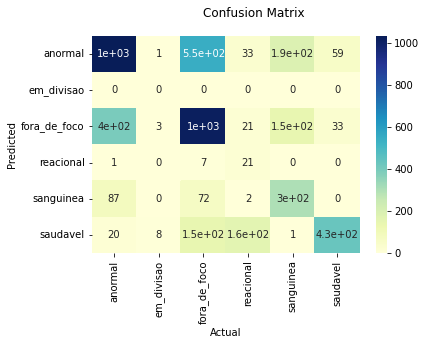

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f43a6bcab50>)

In [ ]:
evaluation_test.show_confusion_matrix()